### The MIT License (MIT)

### Copyright 2025 Natalia Stekolnikova

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<h1 style="background-color:rgb(67, 194, 50); text-align: center"> Credit Risk Analysis System</h1>

**Objective**
This notebook aims to build a clean and analyzable dataset of corporate financial metrics sourced from the SEC EDGAR database. This data will later serve as the foundation for PowerBI reports capable of highlighting the company financial status and credit risk.
In this notebook, we perform ETL (Extract, Transform, Load) steps and EDA (Exploratory Data Analysis).

**Data Source**
We use publicly available data from the SEC EDGAR portal, specifically the Financial Statement and Notes Datasets: https://www.sec.gov/data-research/sec-markets-data/financial-statement-notes-data-sets.

These datasets include structured financial statements and explanatory notes submitted by publicly traded U.S. companies, typically as part of annual reports (10-K forms). The data is extracted directly from XBRL filings and organized into machine-readable tables.

Documentation of file structure, scope, and field definitions is provided in the official technical specification: https://www.sec.gov/files/dera/data/financial-statement-notes-data-sets/2025_02_notes.zip

These resources contain:
- Company identifiers (CIK, form type, filing date)
- Detailed financial metrics, including:
- Assets and liabilities
- Revenue, income, and earnings per share
- Cash flow statements
- Liquidity, solvency, and profitability ratios
- Footnotes and textual metadata that may indicate risk, uncertainty, or early signals of financial distress

The data is structured across several normalized tables such as sub.tsv, num.tsv, etc., which can be joined using common keys.

In [2]:
# %conda init
# %conda deactivate
# %conda activate credit-analysis-dashboard
# %conda install numpy pandas requests bs4 tqdm openai matplotlib seaborn scipy scikit-learn ipython

# %conda install -c conda-forge ratelimit lxml statsmodels 
# %conda install conda-forge::nltk

In [7]:
import numpy as np
import pandas as pd
import os

import requests
from zipfile import ZipFile, BadZipFile
from datetime import datetime
import os

<h2 style="background-color: #ffd5cd; text-align: center">ELT-Extract</h2>

In [5]:
# # Base URL for the reports
# base_url = "https://www.sec.gov/files/dera/data/financial-statement-notes-data-sets/{}_{}_notes.zip"

# # Local directory to save the files
# local_dir = "../data/raw/"
# os.makedirs(local_dir, exist_ok=True)

# # Current year and month
# current_year = datetime.now().year
# current_month = datetime.now().month - 1

# # Iterate over the last 10 years
# for year in range(current_year - 10, current_year):
#     url = base_url.format(year, f"{current_month:02d}")
#     local_filename = f"{local_dir}{year}_{current_month:02d}_notes.zip"

#     # Download the file
#     headers = {
#         "User-Agent": "NataliaStekolnikova-FinRiskApp/1.0 (natalia.a.stekolnikova@gmail.com)",
#         "Accept-Encoding": "gzip, deflate",
#         "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
#         "Connection": "keep-alive",
#         "Host": "www.sec.gov",
#         "Referer": "https://www.sec.gov/",
#         "From": "natalia.a.stekolnikova@gmail.com"
#     }
#     response = requests.get(url, headers=headers, stream=True)
#     if response.status_code == 200:
#         with open(local_filename, "wb") as f:
#             for chunk in response.iter_content(chunk_size=8192):
#                 f.write(chunk)
#         print(f"Downloaded: {local_filename}")

#         # Extract the zip
#         try:
#             with ZipFile(local_filename, 'r') as zip_ref:
#                 extract_path = f"{local_dir}{year}_{current_month:02d}_notes/"
#                 os.makedirs(extract_path, exist_ok=True)
#                 zip_ref.extractall(extract_path)
#                 print(f"Extracted to {extract_path}")
#         except BadZipFile:
#             print(f"Error: The downloaded file for {year} is not a valid ZIP file.")
#     else:
#         print(f"Failed to download file for {year}. Status code: {response.status_code}")


Failed to download file for 2015. Status code: 404
Failed to download file for 2016. Status code: 404
Failed to download file for 2017. Status code: 404
Failed to download file for 2018. Status code: 404
Failed to download file for 2019. Status code: 404
Failed to download file for 2020. Status code: 404
Downloaded: ../data/raw/2021_04_notes.zip
Extracted to ../data/raw/2021_04_notes/
Downloaded: ../data/raw/2022_04_notes.zip
Extracted to ../data/raw/2022_04_notes/
Failed to download file for 2023. Status code: 404
Downloaded: ../data/raw/2024_04_notes.zip
Extracted to ../data/raw/2024_04_notes/


<h2 style="background-color: #ffd5cd; text-align: center">ELT-Load</h2>

### Overview: SEC Financial Statement Data — File Utility for Predictive Modeling

| File        | Description                                                                                      | Use for Modeling                                                               |
|-------------|--------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------|
| `num.tsv`   | Contains actual **financial values** (e.g., revenue, net income, assets, liabilities).           | **Core dataset** for training features and targets.                           |
| `sub.tsv`   | Metadata: company ID (CIK), name, SIC, reporting period, form type (10-K, 10-Q), etc.            | Used to **filter and contextualize** `num.tsv` data.                          |
| `tag.tsv`   | Dictionary of all tags: names, labels, definitions, and whether standard or custom.              | Helps map tags to consistent financial concepts (e.g., revenue, income, etc). |
| `dim.tsv`   | Dimension info (e.g., data by business segments, geographic regions).                            | Used to **filter for consolidated data** or include segment-level details.    |
| `pre.tsv`   | Shows how line items appear in statements (e.g., order, section, label).                         | Useful for **resolving ambiguous/custom tags**.                               |
| `cal.tsv`   | Arithmetic relationships (e.g., which tags sum to totals).                                        | Optional: **reconstruct or validate missing/aggregated values**.              |
| `ren.tsv`   | Report rendering structure for display in SEC viewer.                                            | Not relevant for prediction modeling.                                       |
| `txt.tsv`   | Text blocks (e.g., accounting policies, risk notes, disclosures).                                 | Only useful for **NLP-based analysis**, not for numeric modeling.          |


In [12]:
# Define the years of interest
years_of_interest = [2025]
current_month = datetime.now().month - 1

# Define the input directory template
DATA_INPUT_DIR_TEMPLATE = "../data/raw/{year}_{current_month:02d}_notes/"

# List of file names to load
file_names = ["sub", "num", "tag", "cal", "dim", "pre", "ren", "txt"]

# Initialize a dictionary to store DataFrames for each year
dataframes_by_year = {}

# Iterate over the years of interest
for year in years_of_interest:
    # Format the input directory for the current year and month
    year_input_dir = DATA_INPUT_DIR_TEMPLATE.format(year=year, current_month=current_month)
    
    if os.path.exists(year_input_dir):
        # Load each .tsv file into a DataFrame and store it in the dictionary
        dataframes_by_year[year] = {
            file_name: pd.read_csv(
                os.path.join(year_input_dir, f"{file_name}.tsv"), 
                sep='\t', 
                low_memory=False
            )
            for file_name in file_names
        }
        print(f"Data for year {year} loaded successfully from {year_input_dir}")
    else:
        print(f"Directory for year {year} does not exist: {year_input_dir}")

# Concatenate data for each file type across all years, only if there is data to concatenate
file_dataframes = {}
for file_type in file_names:
    dfs = [dataframes_by_year[year][file_type] for year in years_of_interest if year in dataframes_by_year and file_type in dataframes_by_year[year]]
    if dfs:
        file_dataframes[file_type] = pd.concat(dfs, ignore_index=True)
    else:
        print(f"Warning: No data found for file type '{file_type}'.")
        file_dataframes[file_type] = pd.DataFrame()

sub = file_dataframes['sub']
num = file_dataframes['num']
tag = file_dataframes['tag']
cal = file_dataframes['cal']
dim = file_dataframes['dim']
pre = file_dataframes['pre']
ren = file_dataframes['ren']
txt = file_dataframes['txt']


Data for year 2025 loaded successfully from ../data/raw/2025_04_notes/


In [ ]:
# df2025 = pd.read_csv("../data/processed/2025_02_notes/financial_summary_2025.csv")
# df2024 = pd.read_csv("../data/processed/2025_02_notes/financial_summary_2024.csv")
# df2022 = pd.read_csv("../data/processed/2025_02_notes/financial_summary_2022.csv")
# df2021 = pd.read_csv("../data/processed/2025_02_notes/financial_summary_2021.csv")

# # Combine all dataframes into one
# united_df = pd.concat([df2025, df2024, df2022, df2021], ignore_index=True)

# # Define the output file path
# output_file_path = "../data/processed/2025_02_notes/financial_summary.csv"

# # Export the united dataframe to a CSV file
# united_df.to_csv(output_file_path, index=False)

# print(f"Combined data exported successfully to {output_file_path}")
# # united_df[united_df['name'].str.contains('NVIDIA CORP', case=False, na=False)].head(10).transpose()

Combined data exported successfully to C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/financial_summary.csv


<h2 style="background-color: #ffd5cd; text-align: center">Exploratory Data Analysis (EDA)</h2>

In [13]:
sub.tail(5).transpose()

,9595,9596,9597,9598,9599
adsh,0001993004-25-000086,0001999371-25-004974,0001999371-25-005130,0002003881-25-000035,0002026448-25-000043
cik,1993004,1430306,889348,2003881,2026448
name,"NORTHWESTERN ENERGY GROUP, INC.",TONIX PHARMACEUTICALS HOLDING CORP.,CPI AEROSTRUCTURES INC,"STIRLING HOTELS & RESORTS, INC.",PRINCIPAL CREDIT REAL ESTATE INCOME TRUST
sic,4931.0,2834.0,3728.0,6798.0,6798.0
countryba,US,US,US,US,US
stprba,SD,NJ,NY,TX,IA
cityba,SIOUX FALLS,CHATHAM,EDGEWOOD,DALLAS,DES MOINES
zipba,57108,07928,11717,75254,50392
bas1,3010 WEST 69TH STREET,"26 MAIN STREET, SUITE 101",200A EXECUTIVE DR,14185 DALLAS PARKWAY,711 HIGH STREET
bas2,NaN,NaN,NaN,SUITE 1200,NaN


In [14]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         9600 non-null   object 
 1   cik          9600 non-null   int64  
 2   name         9600 non-null   object 
 3   sic          9235 non-null   float64
 4   countryba    9552 non-null   object 
 5   stprba       8769 non-null   object 
 6   cityba       9587 non-null   object 
 7   zipba        9541 non-null   object 
 8   bas1         9588 non-null   object 
 9   bas2         4189 non-null   object 
 10  baph         9591 non-null   object 
 11  countryma    9538 non-null   object 
 12  stprma       8778 non-null   object 
 13  cityma       9574 non-null   object 
 14  zipma        9526 non-null   object 
 15  mas1         9572 non-null   object 
 16  mas2         4181 non-null   object 
 17  countryinc   8691 non-null   object 
 18  stprinc      7826 non-null   object 
 19  ein   

In [15]:
sub.describe()

,cik,sic,ein,changed,wksi,fye,period,fy,filed,prevrpt,detail,nciks,pubfloatusd,floatdate,floatmems
count,9.600000e+03,9235.000000,9.600000e+03,5.546000e+03,9600.000000,9537.000000,9.379000e+03,1832.000000,9.600000e+03,9600.000000,9600.000000,9600.000000,6.690000e+02,6.700000e+02,670.000000
mean,1.322705e+06,4898.738928,4.310934e+08,2.008941e+07,0.019271,1152.481703,2.024885e+07,2024.383734,2.025042e+07,0.000625,0.171146,1.015729,9.632746e+09,2.024034e+07,1.002985
std,5.365862e+05,1968.015123,3.419352e+08,1.153902e+05,0.137482,236.770887,1.342484e+04,0.500811,9.525915e+00,0.024993,0.376656,0.234672,1.354870e+11,2.829320e+03,0.054595
min,1.750000e+03,100.000000,0.000000e+00,1.960020e+07,0.000000,120.000000,1.899123e+07,2023.000000,2.025040e+07,0.000000,0.000000,1.000000,0.000000e+00,2.020123e+07,1.000000
25%,1.006045e+06,2890.000000,1.132892e+08,2.000082e+07,0.000000,1231.000000,2.025033e+07,2024.000000,2.025041e+07,0.000000,0.000000,1.000000,4.253895e+06,2.024063e+07,1.000000
50%,1.464423e+06,4941.000000,3.827286e+08,2.011123e+07,0.000000,1231.000000,2.025033e+07,2024.000000,2.025042e+07,0.000000,0.000000,1.000000,1.682922e+07,2.024063e+07,1.000000
75%,1.759685e+06,6500.000000,8.139034e+08,2.019052e+07,0.000000,1231.000000,2.025043e+07,2025.000000,2.025043e+07,0.000000,0.000000,1.000000,9.923082e+07,2.024063e+07,1.000000
max,2.059436e+06,8900.000000,1.000000e+09,2.025011e+07,1.000000,1231.000000,2.025123e+07,2026.000000,2.025043e+07,1.000000,1.000000,14.000000,2.440211e+12,2.025063e+07,2.000000


In [16]:
num.head(5)

,adsh,tag,version,ddate,qtrs,uom,dimh,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
0,0000004962-25-000045,AccountsPayableCurrentAndNoncurrent,us-gaap/2024,20241231,0,USD,0x00000000,0,1.388400e+10,NaN,0,0,NaN,0.0,0.0,-6
1,0000004962-25-000045,AccountsPayableCurrentAndNoncurrent,us-gaap/2024,20250331,0,USD,0x00000000,0,1.356400e+10,NaN,0,0,NaN,0.0,0.0,-6
2,0000004962-25-000045,AccumulatedDepreciationDepletionAndAmortizatio...,us-gaap/2024,20241231,0,USD,0x00000000,0,1.073900e+10,NaN,0,0,NaN,0.0,0.0,-6
3,0000004962-25-000045,AccumulatedDepreciationDepletionAndAmortizatio...,us-gaap/2024,20250331,0,USD,0x00000000,0,1.113000e+10,NaN,0,0,NaN,0.0,0.0,-6
4,0000004962-25-000045,AccumulatedOtherComprehensiveIncomeLossNetOfTax,us-gaap/2024,20241231,0,USD,0x00000000,0,-3.395000e+09,NaN,0,0,NaN,0.0,0.0,-6


In [17]:
num.describe()

,ddate,qtrs,iprx,value,footlen,dimn,durp,datp,dcml
count,2.255121e+06,2.255121e+06,2.255121e+06,2.158901e+06,2.255121e+06,2.255121e+06,2.255121e+06,2.255121e+06,2.255121e+06
mean,2.023656e+07,1.740911e+00,1.162452e-01,9.772519e+12,9.954530e-01,9.530872e-01,3.403191e-03,2.026055e-02,1.133433e+03
std,1.113982e+04,1.984965e+00,4.686374e-01,6.367232e+15,3.110607e+01,9.790189e-01,2.875961e-02,1.809703e+00,1.129387e+04
min,1.870123e+07,0.000000e+00,0.000000e+00,-2.677922e+14,0.000000e+00,0.000000e+00,-4.958899e-01,-1.500000e+01,-3.276800e+04
25%,2.023123e+07,0.000000e+00,0.000000e+00,1.900000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.000000e+00
50%,2.024093e+07,1.000000e+00,0.000000e+00,1.600000e+06,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00
75%,2.024123e+07,4.000000e+00,0.000000e+00,7.667400e+07,0.000000e+00,1.000000e+00,1.095891e-02,0.000000e+00,0.000000e+00
max,2.050043e+07,1.370000e+02,4.900000e+01,4.969053e+18,7.394000e+03,7.000000e+00,4.958910e-01,1.500000e+01,3.276700e+04


In [18]:
num['value'] = num['value'].apply(lambda x: round(x, 2) if pd.notnull(x) else x)

In [19]:
num.head(5)

,adsh,tag,version,ddate,qtrs,uom,dimh,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
0,0000004962-25-000045,AccountsPayableCurrentAndNoncurrent,us-gaap/2024,20241231,0,USD,0x00000000,0,1.388400e+10,NaN,0,0,NaN,0.0,0.0,-6
1,0000004962-25-000045,AccountsPayableCurrentAndNoncurrent,us-gaap/2024,20250331,0,USD,0x00000000,0,1.356400e+10,NaN,0,0,NaN,0.0,0.0,-6
2,0000004962-25-000045,AccumulatedDepreciationDepletionAndAmortizatio...,us-gaap/2024,20241231,0,USD,0x00000000,0,1.073900e+10,NaN,0,0,NaN,0.0,0.0,-6
3,0000004962-25-000045,AccumulatedDepreciationDepletionAndAmortizatio...,us-gaap/2024,20250331,0,USD,0x00000000,0,1.113000e+10,NaN,0,0,NaN,0.0,0.0,-6
4,0000004962-25-000045,AccumulatedOtherComprehensiveIncomeLossNetOfTax,us-gaap/2024,20241231,0,USD,0x00000000,0,-3.395000e+09,NaN,0,0,NaN,0.0,0.0,-6


In [20]:
num.describe()

,ddate,qtrs,iprx,value,footlen,dimn,durp,datp,dcml
count,2.255121e+06,2.255121e+06,2.255121e+06,2.158901e+06,2.255121e+06,2.255121e+06,2.255121e+06,2.255121e+06,2.255121e+06
mean,2.023656e+07,1.740911e+00,1.162452e-01,9.772519e+12,9.954530e-01,9.530872e-01,3.403191e-03,2.026055e-02,1.133433e+03
std,1.113982e+04,1.984965e+00,4.686374e-01,6.367232e+15,3.110607e+01,9.790189e-01,2.875961e-02,1.809703e+00,1.129387e+04
min,1.870123e+07,0.000000e+00,0.000000e+00,-2.677922e+14,0.000000e+00,0.000000e+00,-4.958899e-01,-1.500000e+01,-3.276800e+04
25%,2.023123e+07,0.000000e+00,0.000000e+00,1.900000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-5.000000e+00
50%,2.024093e+07,1.000000e+00,0.000000e+00,1.600000e+06,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,-3.000000e+00
75%,2.024123e+07,4.000000e+00,0.000000e+00,7.667400e+07,0.000000e+00,1.000000e+00,1.095891e-02,0.000000e+00,0.000000e+00
max,2.050043e+07,1.370000e+02,4.900000e+01,4.969053e+18,7.394000e+03,7.000000e+00,4.958910e-01,1.500000e+01,3.276700e+04


In [21]:
num.sort_values(by='value', ascending=False).head(5)

,adsh,tag,version,ddate,qtrs,uom,dimh,iprx,value,footnote,footlen,dimn,coreg,durp,datp,dcml
1018080,0001213900-25-035593,BankLiquiditySituationAmount,0001213900-25-035593,20241231,4,CLP,0x4ddd8d19e4ff37c41a77fc7de933d2f0,0,4.969053e+18,NaN,0,1,NaN,0.0,0.0,-6
1018082,0001213900-25-035593,BankLiquiditySituationAmount,0001213900-25-035593,20241231,4,CLP,0x7fb2d6e07f24e226cf79fa709668c381,0,4.969011e+18,NaN,0,1,NaN,0.0,0.0,-6
1018079,0001213900-25-035593,BankLiquiditySituationAmount,0001213900-25-035593,20241231,4,CLP,0x2c0b899a98d875e49ffc22d0bb15a8e3,0,4.272436e+18,NaN,0,1,NaN,0.0,0.0,-6
1018081,0001213900-25-035593,BankLiquiditySituationAmount,0001213900-25-035593,20241231,4,CLP,0x62b09509aa7da31d8a599231a87cf0c8,0,4.272395e+18,NaN,0,1,NaN,0.0,0.0,-6
896493,0001193125-25-104983,FinancialEffectOfContingentLiabilities,0001193125-25-104983,20241231,0,IDR,0x6294a18184084dd6715a083bd3ec3a3d,0,9.024000e+17,NaN,0,6,NaN,0.0,0.0,-6


In [22]:
tag.head(2)

,tag,version,custom,abstract,datatype,iord,crdr,tlabel,doc
0,A.WilliamHigginsMember,0001628280-25-016378,1,1,member,NaN,NaN,A. William Higgins [Member],NaN
1,A.WilliamSteinMember,0001308179-25-000509,1,0,member,D,NaN,A. William Stein [Member],NaN


In [23]:
tag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301718 entries, 0 to 301717
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   tag       301718 non-null  object
 1   version   301718 non-null  object
 2   custom    301718 non-null  int64 
 3   abstract  301718 non-null  int64 
 4   datatype  281540 non-null  object
 5   iord      181249 non-null  object
 6   crdr      91982 non-null   object
 7   tlabel    301575 non-null  object
 8   doc       235863 non-null  object
dtypes: int64(2), object(7)
memory usage: 20.7+ MB


In [24]:
tag.describe()

,custom,abstract
count,301718.000000,301718.000000
mean,0.922699,0.399184
std,0.267068,0.489731
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [20]:
# the tag dataset is NOT useful for our analysis

In [25]:
cal.head(2)

,adsh,grp,arc,negative,ptag,pversion,ctag,cversion
0,0001558370-25-004843,8,2,1,AccountsPayableAndAccruedLiabilitiesCurrent,us-gaap/2023,AccruedGeneralExpenses,0001558370-25-004843
1,0001558370-25-004843,8,3,1,AccountsPayableAndAccruedLiabilitiesCurrent,us-gaap/2023,AccruedInsurancePremiums,0001558370-25-004843


In [26]:
cal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209684 entries, 0 to 209683
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   adsh      209684 non-null  object
 1   grp       209684 non-null  int64 
 2   arc       209684 non-null  int64 
 3   negative  209684 non-null  int64 
 4   ptag      209684 non-null  object
 5   pversion  209684 non-null  object
 6   ctag      209684 non-null  object
 7   cversion  209684 non-null  object
dtypes: int64(3), object(5)
memory usage: 12.8+ MB


In [27]:
cal.describe()

,grp,arc,negative
count,209684.000000,209684.000000,209684.000000
mean,7.156373,11.416622,0.615603
std,6.156946,10.668430,0.788059
min,1.000000,1.000000,-1.000000
25%,3.000000,3.000000,1.000000
50%,5.000000,8.000000,1.000000
75%,10.000000,17.000000,1.000000
max,56.000000,94.000000,1.000000


In [24]:
# the cal dataset could be useful if we need a mapping between previous tag and current tag
# but we don't need it for now

In [28]:
dim.head(5)

,dimhash,segments,segt
0,0x00000000,NaN,0
1,0x00005e9dc4ce39d3bbbe8a6d741ace9a,PropertyPlantAndEquipmentByType=MontmartreDfAn...,0
2,0x000061464924a01d979b2e161ae641d1,ClassesOfLiabilities=Tax;ClassesOfProvisions=I...,0
3,0x0000d669546b5e8518d9f602e93b8b5a,FinancialInstrument=FixedRateResidentialMortgage;,0
4,0x0000f3cda15fef413e6aea34555d2923,CarryingAmountAccumulatedDepreciationAmortisat...,0


In [29]:
dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199485 entries, 0 to 199484
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   dimhash   199485 non-null  object
 1   segments  199484 non-null  object
 2   segt      199485 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


In [30]:
dim.describe()

,segt
count,199485.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [28]:
# the dim dataset is NOT useful for our analysis

In [31]:
pre.head(2)

,adsh,report,line,stmt,inpth,tag,version,prole,plabel,negating
0,0000355811-25-000013,1,5,NaN,0,AmendmentFlag,dei/2023,terseLabel,Amendment Flag,0
1,0000357173-25-000026,1,22,NaN,0,AmendmentFlag,dei/2023,label,Amendment Flag,0


In [32]:
pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1625129 entries, 0 to 1625128
Data columns (total 10 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   adsh      1625129 non-null  object
 1   report    1625129 non-null  int64 
 2   line      1625129 non-null  int64 
 3   stmt      315988 non-null   object
 4   inpth     1625129 non-null  int64 
 5   tag       1625129 non-null  object
 6   version   1625129 non-null  object
 7   prole     1625129 non-null  object
 8   plabel    1625113 non-null  object
 9   negating  1625129 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 124.0+ MB


In [31]:
# the pre dataset is NOT useful for our analysis

In [33]:
ren.head(2)

,adsh,report,rfile,menucat,shortname,longname,roleuri,parentroleuri,parentreport,ultparentrpt
0,0000003545-25-000045,1,H,C,Cover Page,0000001 - Document - Cover Page,http://www.alicoinc.com/role/CoverPage,NaN,NaN,NaN
1,0000003545-25-000062,1,H,C,Cover Page,0000001 - Document - Cover Page,http://www.alicoinc.com/role/CoverPage,NaN,NaN,NaN


In [34]:
ren.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142721 entries, 0 to 142720
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   adsh           142721 non-null  object 
 1   report         142721 non-null  int64  
 2   rfile          142721 non-null  object 
 3   menucat        142721 non-null  object 
 4   shortname      142720 non-null  object 
 5   longname       142721 non-null  object 
 6   roleuri        142721 non-null  object 
 7   parentroleuri  41492 non-null   object 
 8   parentreport   41491 non-null   float64
 9   ultparentrpt   79289 non-null   float64
dtypes: float64(2), int64(1), object(7)
memory usage: 10.9+ MB


In [34]:
# the ren dataset is NOT useful for our analysis

In [35]:
txt.tail(3)

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
454163,0002039852-25-000073,SolicitingMaterial,dei/2025,20250430,0,0,en-US,32767,0.0,6.0,0x00000000,0,NaN,0,5,5,NaN,0,AsOf2025-04-24,false
454164,0002039852-25-000073,TradingSymbol,dei/2025,20250430,0,0,en-US,32767,0.0,6.0,0x00000000,0,NaN,0,4,4,NaN,0,AsOf2025-04-24,TBBK
454165,0002039852-25-000073,WrittenCommunications,dei/2025,20250430,0,0,en-US,32767,0.0,6.0,0x00000000,0,NaN,0,5,5,NaN,0,AsOf2025-04-24,false


In [36]:
txt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454166 entries, 0 to 454165
Data columns (total 20 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   adsh      454166 non-null  object 
 1   tag       454166 non-null  object 
 2   version   454166 non-null  object 
 3   ddate     454166 non-null  int64  
 4   qtrs      454166 non-null  int64  
 5   iprx      454166 non-null  int64  
 6   lang      454166 non-null  object 
 7   dcml      454166 non-null  int64  
 8   durp      454166 non-null  float64
 9   datp      454166 non-null  float64
 10  dimh      454166 non-null  object 
 11  dimn      454166 non-null  int64  
 12  coreg     2405 non-null    object 
 13  escaped   454166 non-null  int64  
 14  srclen    454166 non-null  int64  
 15  txtlen    454166 non-null  int64  
 16  footnote  286 non-null     object 
 17  footlen   454166 non-null  int64  
 18  context   454166 non-null  object 
 19  value     451117 non-null  object 
dtypes: f

txt dataset can be useful for our analysis only if we want to extract some additional or specific Fields from a certain financial report.

<h1 style="background-color: #ffd5cd; text-align: center"> ELT-Transforming</h1>

# Let's start our analysis with the most useful sub and num datasets.

## Explanation of Technical Columns in SEC `num.tsv` / XBRL Data

The following table explains the meaning of some of the more technical columns found in the `num.tsv` file or in XBRL filings from the SEC:

| Column    | Meaning                                                                                     |
|-----------|----------------------------------------------------------------------------------------------|
| `footnote` | Textual note (if any) related to the numeric fact — e.g., exceptions or calculation notes. |
| `footlen`  | Length of the footnote text (in characters). Useful for filtering facts with annotations.   |
| `coreg`    | Co-registrant identifier (if the fact is filed jointly with another company).              |
| `qtrs`     | Number of fiscal quarters covered by the fact. `0 = instant`, `1 = quarter`, `4 = year`, etc. |
| `iprx`     | Internal SEC flag for whether the fact is used as an input in derived calculations.         |
| `dimn`     | Number of XBRL dimensions applied (e.g., by region, business segment, etc.).                |
| `durp`     | Duration of the period (in years or fractions). E.g., `0.25` means one quarter.             |
| `datp`     | Indicates what type of date applies: `1 = instant`, `3 = interval`, `-4 = period end`, etc. |
| `dcml`     | Decimal precision: `-3` means values are in thousands, `0` means no scaling, `32767` = unknown. |


In [37]:
num_filtered = num.drop(columns=['footnote', 'coreg', 'iprx', 'footlen', 'durp', 'datp'])
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2255121 entries, 0 to 2255120
Data columns (total 10 columns):
 #   Column   Dtype  
---  ------   -----  
 0   adsh     object 
 1   tag      object 
 2   version  object 
 3   ddate    int64  
 4   qtrs     int64  
 5   uom      object 
 6   dimh     object 
 7   value    float64
 8   dimn     int64  
 9   dcml     int64  
dtypes: float64(1), int64(4), object(5)
memory usage: 172.1+ MB


In [38]:
# the following sub columns could be useful for our analysis:
sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']].head(4)

,adsh,cik,name,countryba,stprba,cityba,accepted,form,period,fy,fp
0,0000003545-25-000045,3545,"ALICO, INC.",US,FL,"FT. MYERS,",2025-04-01 16:07:00.0,8-K,20250331.0,NaN,NaN
1,0000003545-25-000062,3545,"ALICO, INC.",US,FL,"FT. MYERS,",2025-04-02 08:00:00.0,8-K,20250331.0,NaN,NaN
2,0000003570-25-000043,3570,CHENIERE ENERGY INC,US,TX,HOUSTON,2025-04-02 16:05:00.0,8-K,20250331.0,NaN,NaN
3,0000005272-25-000025,5272,"AMERICAN INTERNATIONAL GROUP, INC.",US,NY,NEW YORK,2025-04-02 17:24:00.0,DEF 14A,20250430.0,NaN,NaN


In [39]:
# the following num columns could be useful for our analysis:
num_filtered[['adsh', 'tag', 'qtrs', 'dimn', 'value', 'version', 'ddate', 'uom']].head(5)

,adsh,tag,qtrs,dimn,value,version,ddate,uom
0,0000004962-25-000045,AccountsPayableCurrentAndNoncurrent,0,0,1.388400e+10,us-gaap/2024,20241231,USD
1,0000004962-25-000045,AccountsPayableCurrentAndNoncurrent,0,0,1.356400e+10,us-gaap/2024,20250331,USD
2,0000004962-25-000045,AccumulatedDepreciationDepletionAndAmortizatio...,0,0,1.073900e+10,us-gaap/2024,20241231,USD
3,0000004962-25-000045,AccumulatedDepreciationDepletionAndAmortizatio...,0,0,1.113000e+10,us-gaap/2024,20250331,USD
4,0000004962-25-000045,AccumulatedOtherComprehensiveIncomeLossNetOfTax,0,0,-3.395000e+09,us-gaap/2024,20241231,USD


In [40]:
columns_to_keep = ['adsh', 'tag', 'qtrs', 'dimn', 'value', 'version', 'ddate', 'uom']
num_filtered = num_filtered[columns_to_keep]
num_filtered.head(5)

,adsh,tag,qtrs,dimn,value,version,ddate,uom
0,0000004962-25-000045,AccountsPayableCurrentAndNoncurrent,0,0,1.388400e+10,us-gaap/2024,20241231,USD
1,0000004962-25-000045,AccountsPayableCurrentAndNoncurrent,0,0,1.356400e+10,us-gaap/2024,20250331,USD
2,0000004962-25-000045,AccumulatedDepreciationDepletionAndAmortizatio...,0,0,1.073900e+10,us-gaap/2024,20241231,USD
3,0000004962-25-000045,AccumulatedDepreciationDepletionAndAmortizatio...,0,0,1.113000e+10,us-gaap/2024,20250331,USD
4,0000004962-25-000045,AccumulatedOtherComprehensiveIncomeLossNetOfTax,0,0,-3.395000e+09,us-gaap/2024,20241231,USD


In [41]:
qtrs_count = num_filtered.groupby('qtrs').size()
print(qtrs_count)

qtrs
0      1058076
1       265688
2        29146
3        24311
4       876926
        ...   
105          5
112         15
116         24
121          1
137          2
Length: 65, dtype: int64


## Interpretation of the `qtrs` Field in SEC `num.tsv`

The `qtrs` column in the `num.tsv` file indicates how many fiscal quarters are covered by the value of a financial metric. This helps interpret the time range over which the reported number is aggregated.

| `qtrs` | Meaning                               | Example Usage                                 |
|--------|----------------------------------------|-----------------------------------------------|
| 0      | Instant value (as of a date)           | For example, balance sheet items (`Assets`)   |
| 1      | One fiscal quarter                     | Quarterly revenue, net income                 |
| 2      | Two quarters (half-year)               | Semiannual reports, 6-K filings, etc.         |
| 3      | Three quarters                         | Cumulative 9-month data                       |
| 4      | Four quarters (full year)              | Annual 10-K filings, 10-Q with `FY` indicator |
| >4     | Extended or non-standard periods       | Possibly multi-year aggregations or anomalies |


In [42]:
num_filtered = num_filtered[num_filtered['qtrs'] <= 4]
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2254147 entries, 0 to 2255120
Data columns (total 8 columns):
 #   Column   Dtype  
---  ------   -----  
 0   adsh     object 
 1   tag      object 
 2   qtrs     int64  
 3   dimn     int64  
 4   value    float64
 5   version  object 
 6   ddate    int64  
 7   uom      object 
dtypes: float64(1), int64(3), object(4)
memory usage: 154.8+ MB


In [ ]:
# Extract count of records grouped by tag from the 'num' DataFrame, ordered by count from greatest to lowest
unique_tags = num['tag'].value_counts().reset_index().sort_values(by='count', ascending=False)
unique_tags.columns = ['Tag', 'Count']
unique_tags.head(10)

output_path = "../data/processed/2025_02_notes/unique_tags.csv"
pd.DataFrame(unique_tags, columns=['Tag', 'Count']).to_csv(output_path, index=False, header=False)

print(f"Tags exported successfully to {output_path}")

Tags exported successfully to ../data/processed/2025_02_notes/unique_tags.csv


## Key Tags for Bank Analysis of Borrower's Solvency

| Category               | Important XBRL Tags                                                | Purpose                                                                 |
|------------------------|---------------------------------------------------------------------|-------------------------------------------------------------------------|
| Liquidity              | `AccountsReceivableNetCurrent`, `AccountsPayableCurrent`, `AccruedLiabilitiesCurrent` | Assessing the ability to cover short-term obligations                  |
| Current Liabilities    | `AccountsPayableCurrentAndNoncurrent`, `AccruedIncomeTaxesNoncurrent`          | Volume of debt and tax liabilities                                     |
| Cash Flow              | `AdjustmentForAmortization`, `AmortizationOfIntangibleAssets`, `NetCashProvidedByUsedInOperatingActivities` | Understanding available cash from core operations (essential for solvency) |
| Capital                | `AdditionalPaidInCapitalCommonStock`, `AccumulatedOtherComprehensiveIncomeLossNetOfTax`, `StockholdersEquity` | Evaluating capital adequacy and net worth                              |
| Asset Depreciation     | `AccumulatedDepreciationDepletionAndAmortization`                          | Assessing the aging or impairment of assets                            |
| Profitability          | `AllocatedShareBasedCompensationExpense`, `NetIncomeLoss`, `Revenues`       | Evaluating income generation and business efficiency                   |
| Total Position         | `Assets`                                                             | Overall size and strength of the company (total holdings and resources)|
| Acquisitions & Growth  | `AcquisitionsNetOfCashAcquiredAllOthers`                                     | Understanding recent expansion, M&A activity, and use of cash          |


In [43]:
# Let's start our analysis with the most useful sub and num datasets.
# the following sub columns could be useful for our analysis:
# sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']].head(1)
# the following num columns could be useful for our analysis:
# num[['adsh', 'tag', 'qtrs', 'dimn', 'value', 'version', 'ddate', 'uom']].head(1)

key_tags = {
    'NetIncomeLoss': 'Net Income',
    'Assets': 'Total Assets',
    'StockholdersEquity': 'Shareholder Equity',
    'NetCashProvidedByUsedInOperatingActivities': 'Cash From Ops',
    'Revenues': 'Revenue',
    'AccountsReceivableNetCurrent': 'Accounts Receivable (Current)',
    'AccountsPayableCurrent': 'Accounts Payable (Current)',
    'AccruedLiabilitiesCurrent': 'Accrued Liabilities (Current)',
    'AccumulatedDepreciationDepletionAndAmortization': 'Accumulated Depreciation/Amortization',
    'AdditionalPaidInCapitalCommonStock': 'Additional Paid-in Capital',
    'AmortizationOfIntangibleAssets': 'Amortization of Intangibles',
    'AllocatedShareBasedCompensationExpense': 'Share-based Compensation Expense'
}

num_filtered = num_filtered[num_filtered['tag'].isin(key_tags.keys())].copy()
num_filtered['metric_name'] = num_filtered['tag'].map(key_tags)
num_filtered = num_filtered.merge(sub[['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']], on='adsh', how='left')

num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106569 entries, 0 to 106568
Data columns (total 19 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adsh         106569 non-null  object 
 1   tag          106569 non-null  object 
 2   qtrs         106569 non-null  int64  
 3   dimn         106569 non-null  int64  
 4   value        101544 non-null  float64
 5   version      106569 non-null  object 
 6   ddate        106569 non-null  int64  
 7   uom          106569 non-null  object 
 8   metric_name  106569 non-null  object 
 9   cik          106569 non-null  int64  
 10  name         106569 non-null  object 
 11  countryba    105786 non-null  object 
 12  stprba       75070 non-null   object 
 13  cityba       106425 non-null  object 
 14  accepted     106569 non-null  object 
 15  form         106569 non-null  object 
 16  period       106376 non-null  float64
 17  fy           91957 non-null   float64
 18  fp           91957 non-n

In [44]:
num_filtered = num_filtered.dropna(subset=['value', 'fy', 'fp'])
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88066 entries, 0 to 106568
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         88066 non-null  object 
 1   tag          88066 non-null  object 
 2   qtrs         88066 non-null  int64  
 3   dimn         88066 non-null  int64  
 4   value        88066 non-null  float64
 5   version      88066 non-null  object 
 6   ddate        88066 non-null  int64  
 7   uom          88066 non-null  object 
 8   metric_name  88066 non-null  object 
 9   cik          88066 non-null  int64  
 10  name         88066 non-null  object 
 11  countryba    87349 non-null  object 
 12  stprba       61373 non-null  object 
 13  cityba       87945 non-null  object 
 14  accepted     88066 non-null  object 
 15  form         88066 non-null  object 
 16  period       88066 non-null  float64
 17  fy           88066 non-null  float64
 18  fp           88066 non-null  object 
dtypes: float

In [45]:
num_filtered['ddate'] = pd.to_datetime(num_filtered['ddate'], format='%Y%m%d').dt.date
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88066 entries, 0 to 106568
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         88066 non-null  object 
 1   tag          88066 non-null  object 
 2   qtrs         88066 non-null  int64  
 3   dimn         88066 non-null  int64  
 4   value        88066 non-null  float64
 5   version      88066 non-null  object 
 6   ddate        88066 non-null  object 
 7   uom          88066 non-null  object 
 8   metric_name  88066 non-null  object 
 9   cik          88066 non-null  int64  
 10  name         88066 non-null  object 
 11  countryba    87349 non-null  object 
 12  stprba       61373 non-null  object 
 13  cityba       87945 non-null  object 
 14  accepted     88066 non-null  object 
 15  form         88066 non-null  object 
 16  period       88066 non-null  float64
 17  fy           88066 non-null  float64
 18  fp           88066 non-null  object 
dtypes: float

In [46]:
# Check for duplicates in the DataFrame
duplicate_count = num_filtered.duplicated().sum()

print(f"Number of duplicate rows in num_filtered: {duplicate_count}")

Number of duplicate rows in num_filtered: 18652


In [47]:
# Find duplicated rows
duplicated_rows = num_filtered[num_filtered.duplicated()]

# Display duplicated rows
duplicated_rows

,adsh,tag,qtrs,dimn,value,version,ddate,uom,metric_name,cik,name,countryba,stprba,cityba,accepted,form,period,fy,fp
8,0000004962-25-000045,Assets,0,0,2.822440e+11,us-gaap/2024,2025-03-31,USD,Total Assets,4962,AMERICAN EXPRESS CO,US,NY,NEW YORK,2025-04-18 12:22:00.0,10-Q,20250331.0,2025.0,Q1
17,0000004962-25-000045,NetIncomeLoss,1,0,2.437000e+09,us-gaap/2024,2024-03-31,USD,Net Income,4962,AMERICAN EXPRESS CO,US,NY,NEW YORK,2025-04-18 12:22:00.0,10-Q,20250331.0,2025.0,Q1
18,0000004962-25-000045,NetIncomeLoss,1,0,2.437000e+09,us-gaap/2024,2024-03-31,USD,Net Income,4962,AMERICAN EXPRESS CO,US,NY,NEW YORK,2025-04-18 12:22:00.0,10-Q,20250331.0,2025.0,Q1
19,0000004962-25-000045,NetIncomeLoss,1,0,2.437000e+09,us-gaap/2024,2024-03-31,USD,Net Income,4962,AMERICAN EXPRESS CO,US,NY,NEW YORK,2025-04-18 12:22:00.0,10-Q,20250331.0,2025.0,Q1
20,0000004962-25-000045,NetIncomeLoss,1,0,2.437000e+09,us-gaap/2024,2024-03-31,USD,Net Income,4962,AMERICAN EXPRESS CO,US,NY,NEW YORK,2025-04-18 12:22:00.0,10-Q,20250331.0,2025.0,Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106445,0001999371-25-004186,NetIncomeLoss,2,0,-3.626530e+05,us-gaap/2024,2024-02-29,USD,Net Income,1445942,TEXAS MINERAL RESOURCES CORP.,US,TX,SIERRA BLANCA,2025-04-14 17:07:00.0,10-Q,20250228.0,2025.0,Q2
106452,0001999371-25-004186,NetIncomeLoss,1,0,-2.419530e+05,us-gaap/2024,2025-02-28,USD,Net Income,1445942,TEXAS MINERAL RESOURCES CORP.,US,TX,SIERRA BLANCA,2025-04-14 17:07:00.0,10-Q,20250228.0,2025.0,Q2
106458,0001999371-25-004186,NetIncomeLoss,2,0,-4.710500e+05,us-gaap/2024,2025-02-28,USD,Net Income,1445942,TEXAS MINERAL RESOURCES CORP.,US,TX,SIERRA BLANCA,2025-04-14 17:07:00.0,10-Q,20250228.0,2025.0,Q2
106475,0001999371-25-004186,StockholdersEquity,0,0,8.638290e+05,us-gaap/2024,2024-08-31,USD,Shareholder Equity,1445942,TEXAS MINERAL RESOURCES CORP.,US,TX,SIERRA BLANCA,2025-04-14 17:07:00.0,10-Q,20250228.0,2025.0,Q2


In [48]:
# Remove duplicate rows from the num_filtered DataFrame
num_filtered = num_filtered.drop_duplicates()

In [49]:
num_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69414 entries, 0 to 106568
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         69414 non-null  object 
 1   tag          69414 non-null  object 
 2   qtrs         69414 non-null  int64  
 3   dimn         69414 non-null  int64  
 4   value        69414 non-null  float64
 5   version      69414 non-null  object 
 6   ddate        69414 non-null  object 
 7   uom          69414 non-null  object 
 8   metric_name  69414 non-null  object 
 9   cik          69414 non-null  int64  
 10  name         69414 non-null  object 
 11  countryba    68820 non-null  object 
 12  stprba       47360 non-null  object 
 13  cityba       69319 non-null  object 
 14  accepted     69414 non-null  object 
 15  form         69414 non-null  object 
 16  period       69414 non-null  float64
 17  fy           69414 non-null  float64
 18  fp           69414 non-null  object 
dtypes: float

In [50]:
# Select numerical columns
numerical_columns = num_filtered.select_dtypes(include=['float64', 'int64']).columns

# Initialize a dictionary to store outliers
outliers = {}

# Detect outliers using the IQR method
for column in numerical_columns:
    Q1 = num_filtered[column].quantile(0.01)
    Q3 = num_filtered[column].quantile(0.99)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers[column] = num_filtered[(num_filtered[column] < lower_bound) | (num_filtered[column] > upper_bound)]

# Display outliers for each column
for column, outlier_data in outliers.items():
    print(f"Outliers in column '{column}':")

Outliers in column 'qtrs':
Outliers in column 'dimn':
Outliers in column 'value':
Outliers in column 'cik':
Outliers in column 'period':
Outliers in column 'fy':


In [51]:
# Check for duplicates in the original long-format data (before pivot)
dupes_before = num_filtered.duplicated(
    subset=['cik', 'name', 'adsh', 'fy', 'fp', 'form', 'dimn', 'metric_name']
).sum()

print(f"Duplicates before pivot (same metric per group): {dupes_before}")

edf = num_filtered.pivot_table(
    index=['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp'],
    columns='metric_name',
    values='value',
).reset_index()

# Check for duplicates in the resulting pivoted table
dupes_after = edf.duplicated(subset=['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted', 'form', 'period', 'fy', 'fp']).sum()

print(f"Duplicates in pivoted edf (same company-report-period): {dupes_after}")

Duplicates before pivot (same metric per group): 53971
Duplicates in pivoted edf (same company-report-period): 0


In [52]:
edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 23 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   adsh                                   1097 non-null   object 
 1   cik                                    1097 non-null   int64  
 2   name                                   1097 non-null   object 
 3   countryba                              1097 non-null   object 
 4   stprba                                 1097 non-null   object 
 5   cityba                                 1097 non-null   object 
 6   accepted                               1097 non-null   object 
 7   form                                   1097 non-null   object 
 8   period                                 1097 non-null   float64
 9   fy                                     1097 non-null   float64
 10  fp                                     1097 non-null   object 
 11  Acco

In [53]:
edf['ROE'] = edf['Net Income'] / edf['Shareholder Equity'].replace(0, np.nan)
edf['ROA'] = edf['Net Income'] / edf['Total Assets'].replace(0, np.nan)
edf['ROI'] = edf['Net Income'] / (edf['Total Assets'] - edf['Accounts Payable (Current)']).replace(0, np.nan)

edf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   adsh                                   1097 non-null   object 
 1   cik                                    1097 non-null   int64  
 2   name                                   1097 non-null   object 
 3   countryba                              1097 non-null   object 
 4   stprba                                 1097 non-null   object 
 5   cityba                                 1097 non-null   object 
 6   accepted                               1097 non-null   object 
 7   form                                   1097 non-null   object 
 8   period                                 1097 non-null   float64
 9   fy                                     1097 non-null   float64
 10  fp                                     1097 non-null   object 
 11  Acco

In [54]:
edf.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
metric_name,,,,,,,,
cik,1097.0,1.193099e+06,5.676595e+05,1.800000e+03,8.853070e+05,1.309082e+06,1.652044e+06,2.047455e+06
period,1097.0,2.024683e+07,4.507682e+03,2.023063e+07,2.024123e+07,2.025023e+07,2.025033e+07,2.025033e+07
fy,1097.0,2.024589e+03,5.014435e-01,2.023000e+03,2.024000e+03,2.025000e+03,2.025000e+03,2.026000e+03
Accounts Payable (Current),663.0,6.393205e+08,2.098019e+09,1.000000e+02,1.827411e+06,2.489550e+07,2.919260e+08,2.412300e+10
Accounts Receivable (Current),582.0,7.706324e+08,3.390281e+09,0.000000e+00,1.516502e+06,6.854750e+07,5.413571e+08,5.431200e+10
Accrued Liabilities (Current),399.0,5.772945e+08,3.213273e+09,0.000000e+00,1.049638e+06,1.416350e+07,1.838218e+08,5.476400e+10
Accumulated Depreciation/Amortization,3.0,-1.479133e+04,0.000000e+00,-1.479133e+04,-1.479133e+04,-1.479133e+04,-1.479133e+04,-1.479133e+04
Additional Paid-in Capital,380.0,3.110813e+09,8.345592e+09,-4.985500e+08,1.716832e+08,7.429592e+08,2.394252e+09,1.077050e+11
Amortization of Intangibles,448.0,1.168278e+08,1.636448e+09,0.000000e+00,3.864202e+05,3.067750e+06,1.624912e+07,3.445525e+10



### Financial Risk Flag Criteria

| Condition                             | Metric              | Threshold          | Reason / Interpretation                                                                 |
|--------------------------------------|---------------------|--------------------|------------------------------------------------------------------------------------------|
| `Current Ratio < 1`                  | Liquidity           | Less than 1        | Company may not be able to cover short-term liabilities with current assets              |
| `Debt to Equity > 2`                 | Leverage            | Greater than 2     | Indicates high reliance on debt, risk of over-leveraging                                 |
| `ROE < 0`                            | Profitability       | Less than 0        | Negative Return on Equity suggests destroying shareholder value                          |
| `ROI < 0`                            | Investment Return   | Less than 0        | Assets are not generating returns; inefficient use of capital                            |
| `Profit Margin < 0`                  | Operational Health  | Less than 0        | Core business is unprofitable                                                            |
| `Missing values in any metric`       | Data Completeness   | Any `NaN`          | Incomplete data makes risk assessment unreliable; treated as potentially risky           |

If **any one** of these conditions is true, the company is classified as **High Risk**.

In [55]:
# Add key financial ratios
edf['Current Ratio'] = edf['Accounts Receivable (Current)'] / edf['Accounts Payable (Current)']
edf['Debt to Equity'] = (edf['Total Assets'] - edf['Shareholder Equity']) / edf['Shareholder Equity']
edf['Profit Margin'] = edf['Net Income'] / edf['Revenue']
edf['Asset Turnover'] = edf['Revenue'] / edf['Total Assets']
edf['ROI'] = edf['Net Income'] / (edf['Total Assets'] - edf['Accounts Payable (Current)'])

edf.replace([np.inf, -np.inf], np.nan, inplace=True)

# Set conditional risk classification
edf['Financial Risk Flag'] = (
    (edf['Current Ratio'] < 1) |
    (edf['Debt to Equity'] > 2) |
    (edf['ROE'] < 0) |
    (edf['ROI'] < 0) |
    (edf['Profit Margin'] < 0) |
    edf[['Current Ratio', 'Debt to Equity', 'ROE', 'ROI', 'Profit Margin']].isnull().any(axis=1)
)

# Assign risk category and create a flag
edf['Risk Category'] = edf['Financial Risk Flag'].map({True: 'High Risk', False: 'Low Risk'})
edf['Risk Flag'] = edf['Financial Risk Flag'].astype(int)

# Group and analyze by report type
summary = edf[['name', 'ROE', 'ROA', 'ROI', 'Current Ratio', 'Debt to Equity', 'Profit Margin', 'Risk Category']].round(2)

# Show distribution by risk category
risk_dist = edf['Risk Category'].value_counts()

# Display results
print("\n--- Financial Risk Distribution ---")
print(risk_dist)

print("\n--- List of non-Risky companies ---")
non_risky_summary = summary[summary['Risk Category'] == 'Low Risk'].head(10)
non_risky_summary



--- Financial Risk Distribution ---
Risk Category
High Risk    1068
Low Risk       29
Name: count, dtype: int64

--- List of non-Risky companies ---


metric_name,name,ROE,ROA,ROI,Current Ratio,Debt to Equity,Profit Margin,Risk Category
24,FLOWSERVE CORP,0.04,0.02,0.03,1.87,0.61,144.03,Low Risk
53,NORTHERN STATES POWER CO /WI/,0.02,0.01,0.01,1.01,1.53,0.12,Low Risk
72,SNAP-ON INC,0.05,0.09,0.10,3.05,-0.49,0.82,Low Risk
90,GRAHAM HOLDINGS CO,0.02,0.01,0.01,3.05,0.79,18.77,Low Risk
92,"EMCOR GROUP, INC.",0.07,0.08,0.12,3.73,-0.05,0.16,Low Risk
101,FEDERAL SIGNAL CORP /DE/,0.13,0.05,0.05,2.30,1.93,0.17,Low Risk
108,SEI INVESTMENTS CO,0.19,0.10,0.10,48.21,0.88,2.48,Low Risk
135,FISERV INC,0.03,0.01,0.01,3.28,1.98,0.52,Low Risk
152,TRIMAS CORP,0.01,0.02,0.02,1.95,-0.20,0.08,Low Risk
178,AMEDISYS INC,0.03,0.03,0.04,9.03,-0.06,0.13,Low Risk


In [56]:
edf.tail(7).transpose()

,1090,1091,1092,1093,1094,1095,1096
metric_name,,,,,,,
adsh,0001967680-25-000067,0001968915-25-000030,0001993004-25-000084,0001995920-25-000012,0001996810-25-000073,0001999371-25-004186,0002035304-25-000006
cik,1967680,1968915,1993004,1995920,1996810,1445942,2035304
name,VERALTO CORP,PHINIA INC.,"NORTHWESTERN ENERGY GROUP, INC.",E-SMART CORP.,GE VERNOVA INC.,TEXAS MINERAL RESOURCES CORP.,TITAN AMERICA SA
countryba,US,US,US,US,US,US,US
stprba,MA,MI,SD,PA,MA,TX,VA
cityba,WALTHAM,AUBURN HILLS,SIOUX FALLS,PHILADELPHIA,CAMBRIDGE,SIERRA BLANCA,NORFOLK
accepted,2025-04-29 17:33:00.0,2025-04-25 10:59:00.0,2025-04-29 18:25:00.0,2025-04-10 13:00:00.0,2025-04-23 06:23:00.0,2025-04-14 17:07:00.0,2025-04-04 16:30:00.0
form,10-Q,10-Q,10-Q,10-Q,10-Q,10-Q,20-F
period,20250331.0,20250331.0,20250331.0,20250228.0,20250331.0,20250228.0,20241231.0


In [57]:
# # output_path = "C:/Users/natal/credit-analysis-dashboard/data/processed/2025_02_notes/"
# output_path = "../data/processed/2025_02_notes/"
# # output_file_path = os.path.join(output_path, f"financial_summary_{years_of_interest[0]}_{current_month:02d}.csv")
# output_file_path = os.path.join(output_path, f"financial_summary_{years_of_interest[0]}.csv")
# edf.to_csv(output_file_path, index=False)
# print(f"Saved: {output_file_path}")

Saved: ../data/processed/2025_02_notes/financial_summary_2025_04.csv


<h2 style="background-color: #ffd5cd; text-align: center">Exploratory Data Analysis (EDA)</h2>

In [58]:
edf.columns

Index(['adsh', 'cik', 'name', 'countryba', 'stprba', 'cityba', 'accepted',
       'form', 'period', 'fy', 'fp', 'Accounts Payable (Current)',
       'Accounts Receivable (Current)', 'Accrued Liabilities (Current)',
       'Accumulated Depreciation/Amortization', 'Additional Paid-in Capital',
       'Amortization of Intangibles', 'Cash From Ops', 'Net Income', 'Revenue',
       'Share-based Compensation Expense', 'Shareholder Equity',
       'Total Assets', 'ROE', 'ROA', 'ROI', 'Current Ratio', 'Debt to Equity',
       'Profit Margin', 'Asset Turnover', 'Financial Risk Flag',
       'Risk Category', 'Risk Flag'],
      dtype='object', name='metric_name')

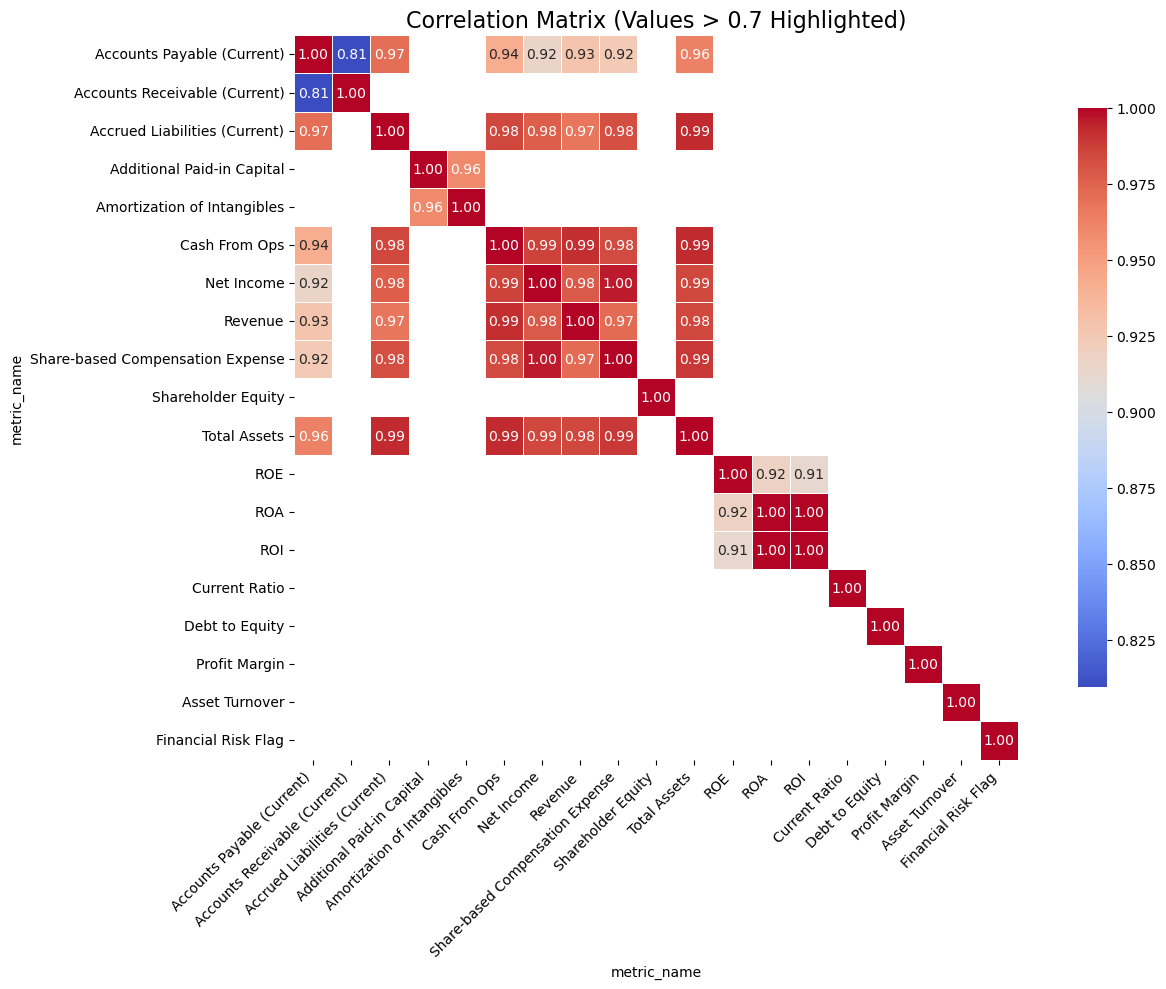

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the specified columns
selected_columns = [
    'Accounts Payable (Current)', 'Accounts Receivable (Current)', 'Accrued Liabilities (Current)',
    'Additional Paid-in Capital', 'Amortization of Intangibles', 'Cash From Ops', 'Net Income', 'Revenue',
    'Share-based Compensation Expense', 'Shareholder Equity', 'Total Assets', 'ROE', 'ROA', 'ROI',
    'Current Ratio', 'Debt to Equity', 'Profit Margin', 'Asset Turnover', 'Financial Risk Flag'
]

# Filter the DataFrame to include only the selected columns
filtered_edf = edf[selected_columns].dropna()

# Calculate correlation matrix
correlation_matrix = filtered_edf.corr()

# Apply a mask to highlight values greater than 0.8
mask = correlation_matrix < 0.8

# Plot correlation heatmap with grid
plt.figure(figsize=(14, 10))
sns.heatmap(
    correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", 
    square=True, cbar_kws={"shrink": 0.8}, linewidths=0.5
)
plt.title("Correlation Matrix (Values > 0.7 Highlighted)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


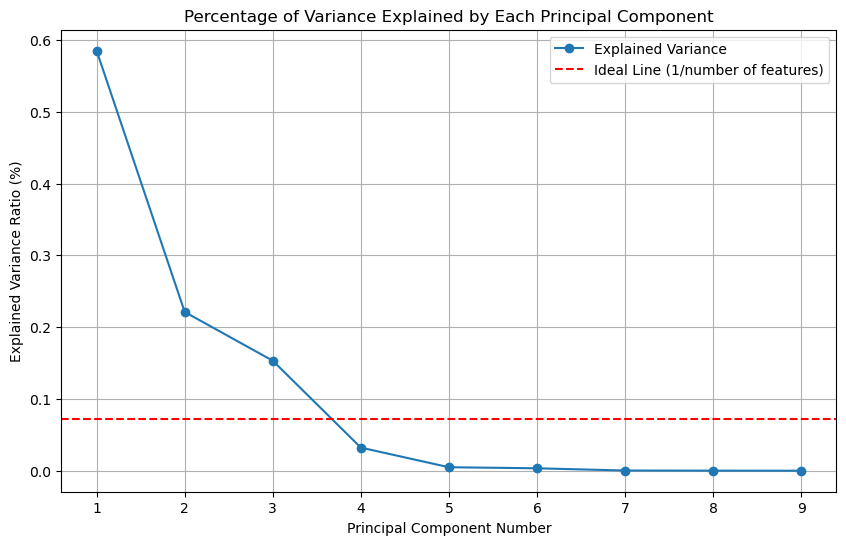

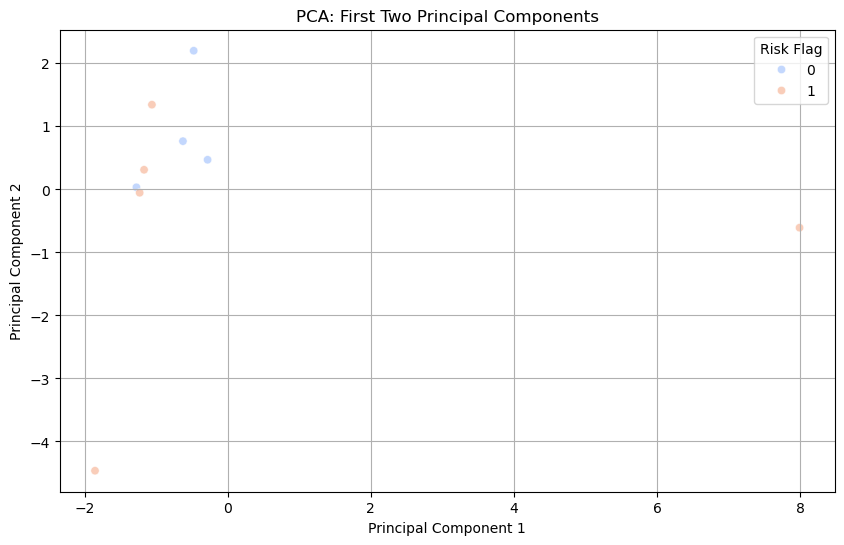


--- PCA Explained Variance Table ---
  Principal Component  Explained Variance Ratio  Cumulative Explained Variance
0                 PC1              5.849197e-01                       0.584920
1                 PC2              2.210682e-01                       0.805988
2                 PC3              1.531946e-01                       0.959183
3                 PC4              3.220772e-02                       0.991390
4                 PC5              4.863877e-03                       0.996254
5                 PC6              3.377624e-03                       0.999632
6                 PC7              2.887579e-04                       0.999921
7                 PC8              7.946976e-05                       1.000000
8                 PC9              3.330199e-33                       1.000000

Number of components needed to explain at least 95% of the variance: 3


In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features and target
features = [
    'Net Income', 'Total Assets', 'Shareholder Equity', 'Cash From Ops', 'Revenue',
    'Accounts Receivable (Current)', 'Accounts Payable (Current)', 'Accrued Liabilities (Current)',
    'Additional Paid-in Capital', 'ROI', 'ROE', 'ROA',
    'Amortization of Intangibles', 'Share-based Compensation Expense'
]
target = 'Risk Flag'

# Drop rows with missing values in the selected features and target
df = edf[features + [target]].dropna()

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Apply PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_features)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(pca_data, columns=[f'PC{i+1}' for i in range(pca_data.shape[1])])
pca_df[target] = df[target].values

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o', label='Explained Variance')
plt.axhline(y=1/len(features), color='r', linestyle='--', label='Ideal Line (1/number of features)')
plt.title('Percentage of Variance Explained by Each Principal Component')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance Ratio (%)')
plt.legend()
plt.grid(True)
plt.show()

# Visualize the first two principal components with respect to the Risk Flag
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=target, palette='coolwarm', alpha=0.7)
plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Risk Flag')
plt.grid(True)
plt.show()

# Create a table summarizing the PCA results
explained_variance = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))],
    'Explained Variance Ratio': pca.explained_variance_ratio_,
    'Cumulative Explained Variance': pca.explained_variance_ratio_.cumsum()
})

# Display the table
print("\n--- PCA Explained Variance Table ---")
print(explained_variance)

# Highlight the number of components needed to explain at least 95% of the variance
components_needed = (explained_variance['Cumulative Explained Variance'] >= 0.95).idxmax() + 1
print(f"\nNumber of components needed to explain at least 95% of the variance: {components_needed}")


In [62]:
# %matplotlib inline
# sns.set(style='whitegrid')

In [61]:
from scipy.stats import ttest_ind, mannwhitneyu
from IPython.display import display, Markdown
from scipy.stats import pearsonr

,Principal Component,Explained Variance (%),Cumulative Variance (%)
0,PC1,58.49,58.49
1,PC2,22.11,80.60
2,PC3,15.32,95.92
3,PC4,3.22,99.14
4,PC5,0.49,99.63
5,PC6,0.34,99.96
6,PC7,0.03,99.99
7,PC8,0.01,100.00
8,PC9,0.00,100.00


**Number of components needed to explain at least 95% of the variance:** `3`

C:\Users\natal\AppData\Local\Temp\ipykernel_20520\1306781792.py:48: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\natal\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


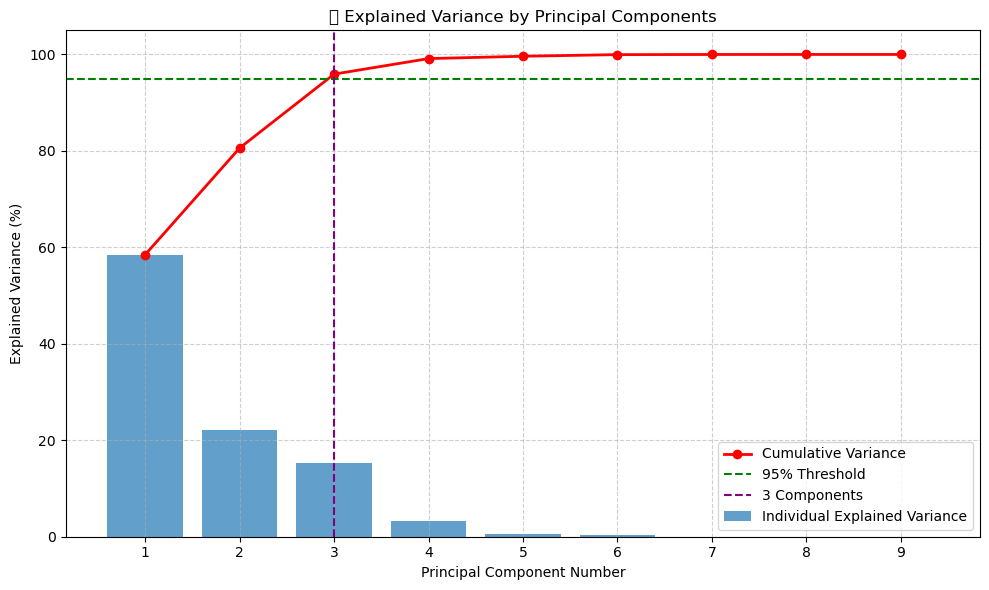

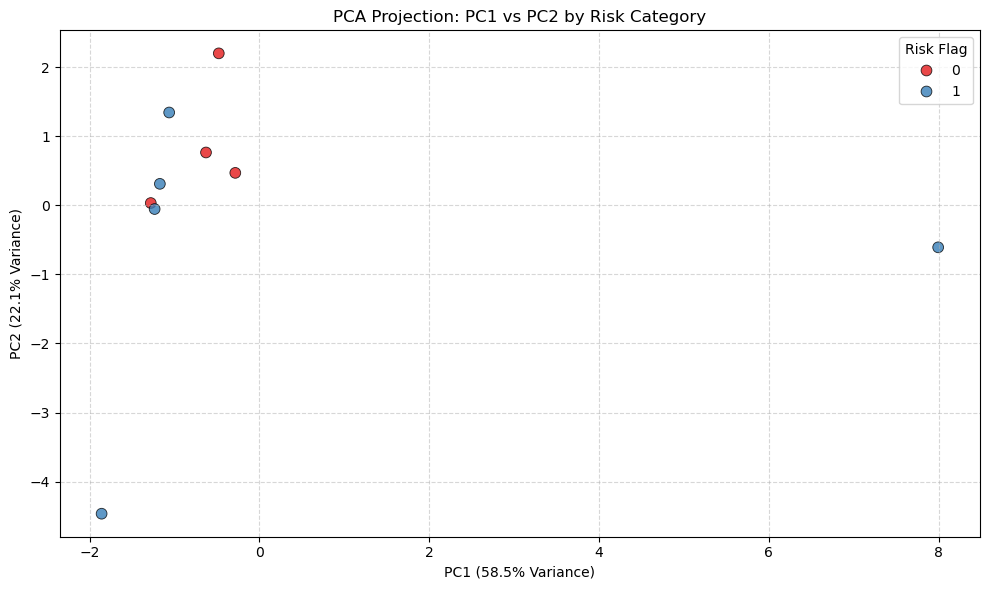

### PCA Loadings (Top 3 Components)

,PC1,PC2,PC3
Total Assets,0.348,-0.039,0.004
Accrued Liabilities (Current),0.348,-0.007,0.046
Cash From Ops,0.346,-0.030,0.021
Share-based Compensation Expense,0.346,-0.041,-0.067
Net Income,0.345,-0.024,-0.070
Revenue,0.343,-0.025,-0.012
Accounts Payable (Current),0.337,0.017,0.115
Accounts Receivable (Current),0.248,0.159,0.258
ROI,0.067,0.515,-0.246
ROA,0.066,0.515,-0.251


In [62]:
features = [
    'Net Income', 'Total Assets', 'Shareholder Equity', 'Cash From Ops', 'Revenue',
    'Accounts Receivable (Current)', 'Accounts Payable (Current)', 'Accrued Liabilities (Current)',
    'Additional Paid-in Capital', 'ROI', 'ROE', 'ROA',
    'Amortization of Intangibles', 'Share-based Compensation Expense'
]
target = 'Risk Flag'

# Drop missing values
df = edf[features + [target]].dropna()

# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])

# Fit PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_features)

# Explained variance
explained = pca.explained_variance_ratio_ * 100
cumulative = explained.cumsum()

explained_variance = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained))],
    'Explained Variance (%)': explained,
    'Cumulative Variance (%)': cumulative
})

display(explained_variance.round(2))

# Components needed to explain at least 95% of the variance
components_needed = (cumulative >= 95).argmax() + 1
display(Markdown(f"**Number of components needed to explain at least 95% of the variance:** `{components_needed}`"))

# Explained variance chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained)+1), explained, alpha=0.7, label='Individual Explained Variance')
plt.plot(range(1, len(cumulative)+1), cumulative, color='red', marker='o', linewidth=2, label='Cumulative Variance')
plt.axhline(y=95, color='green', linestyle='--', label='95% Threshold')
plt.axvline(x=components_needed, color='purple', linestyle='--', label=f'{components_needed} Components')
plt.title('📈 Explained Variance by Principal Components')
plt.xlabel('Principal Component Number')
plt.ylabel('Explained Variance (%)')
plt.xticks(range(1, len(explained)+1))
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Scatter plot of PC1 vs PC2 by Risk Flag
pca_df = pd.DataFrame(pca_data[:, :2], columns=['PC1', 'PC2'])
pca_df[target] = df[target].values

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue=target,
    palette='Set1',
    alpha=0.8,
    s=60,
    edgecolor='black'
)
plt.title(f'PCA Projection: PC1 vs PC2 by Risk Category')
plt.xlabel(f'PC1 ({explained[0]:.1f}% Variance)')
plt.ylabel(f'PC2 ({explained[1]:.1f}% Variance)')
plt.legend(title='Risk Flag', loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# PCA loadings
display(Markdown("### PCA Loadings (Top 3 Components)"))
loadings = pd.DataFrame(
    pca.components_.T[:, :3],
    columns=['PC1', 'PC2', 'PC3'],
    index=features
).sort_values(by='PC1', ascending=False)

display(loadings.round(3))

### Explanation

- The four component explain 77% of the variance.

- Components PC4 and onward explain virtually nothing — they are computational artifacts or reflect perfect multicollinearity in the data.

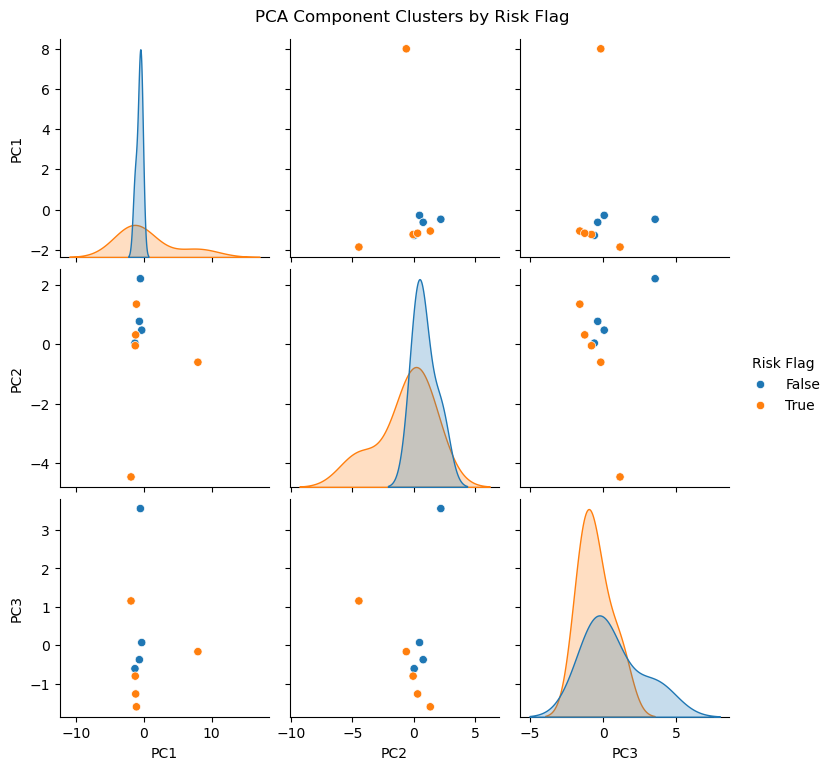

In [63]:
pca_df = pd.DataFrame(pca_data[:, :3], columns=['PC1', 'PC2', 'PC3'])
pca_df['Risk Flag'] = edf.loc[df.index, 'Financial Risk Flag'].values  # if using flag

sns.pairplot(pca_df, hue='Risk Flag', diag_kind='kde')
plt.suptitle('PCA Component Clusters by Risk Flag', y=1.02)
plt.show()

### Distribution Insights (Diagonals)

PC1: Wide spread with strong right skew (some risky companies show very large PC1 scores)

PC2 and PC3: Most values tightly clustered around 0, with some extreme outliers

In [64]:
loadings = pd.DataFrame(
    pca.components_.T[:, :3],
    columns=['PC1', 'PC2', 'PC3'],
    index=features
).sort_values(by='PC1', ascending=False)

display(loadings)

,PC1,PC2,PC3
Total Assets,0.348435,-0.038760,0.003933
Accrued Liabilities (Current),0.348046,-0.006780,0.045640
Cash From Ops,0.346151,-0.030045,0.021429
Share-based Compensation Expense,0.345896,-0.041174,-0.067251
Net Income,0.345077,-0.023934,-0.070397
Revenue,0.342770,-0.025170,-0.012452
Accounts Payable (Current),0.337016,0.017441,0.115234
Accounts Receivable (Current),0.247969,0.159186,0.257937
ROI,0.066944,0.515422,-0.246328
ROA,0.065829,0.515046,-0.251386


### PCA Summary

#### PC1 – Financial Size & Operational Strength
**Top contributors**: Shareholder Equity, Cash From Ops, Net Income, Accrued Liabilities, Total Assets, Revenue  
**Interpretation**: Captures company size and overall financial activity. Higher values reflect larger, more operationally active firms.

#### PC2 – Return Efficiency
**Top contributors**: ROA, ROI, Net Income  
**Interpretation**: Represents return-based efficiency. Differentiates firms by how effectively they generate returns on assets and investments.

#### PC3 – Capital Structure & Intangibles
**Top contributors**: Additional Paid-in Capital, Amortization of Intangibles  
**Negative contributors**: Revenue, Accounts Receivable, Accrued Liabilities  
**Interpretation**: Highlights contrast between firms driven by equity funding/intangibles versus those generating revenue from operations.


## Central Tendency for Feaures by Risk Category (With Outlier Control)
This analysis computes robust central tendency and dispersion statistics for key financial metrics across Low Risk and High Risk companies. To ensure results are not distorted by extreme values, the top and bottom 1% of outliers are removed based on each metric's overall distribution.

For each risk group and metric, the following statistics are calculated:
- Count (number of valid observations)
- Mean, Median, Mode
- Minimum and Maximum (within trimmed range)
- Standard Deviation

This breakdown enables a clear, side-by-side comparison of how financial health indicators vary across different levels of investment risk. It also supports further hypothesis testing, risk modeling, and visualization with a cleaner and more interpretable dataset.

In [65]:
# Metrics to evaluate
features = [
    'Current Ratio', 'Debt to Equity', 'ROE', 'ROA', 'ROI', 'Profit Margin'
]

df_valid = edf[features].dropna()

df_valid = edf.dropna(subset=['Risk Category'])

# Initialize list for results
summary_stats = []

# Loop over metrics and risk groups
for feature in features:
    # Calculate overall bounds for outlier removal
    lower = df_valid[feature].quantile(0.01)
    upper = df_valid[feature].quantile(0.99)

    for risk_group in ['Low Risk', 'High Risk']:
        group_data = df_valid[df_valid['Risk Category'] == risk_group][feature].dropna()
        
        # Remove outliers
        trimmed = group_data[(group_data >= lower) & (group_data <= upper)]

        stats = {
            'Metric': feature,
            'Risk Group': risk_group,
            'Count': len(trimmed),
            'Mean': round(trimmed.mean(), 2),
            'Median': round(trimmed.median(), 2),
            'Mode': round(trimmed.mode().iloc[0], 2) if not trimmed.mode().empty else 'N/A',
            'Min': round(trimmed.min(), 2),
            'Max': round(trimmed.max(), 2),
            'Std Dev': round(trimmed.std(), 2)
        }

        summary_stats.append(stats)

# Convert to DataFrame and display
summary_df = pd.DataFrame(summary_stats)

print("\n--- Central Tendency and Dispersion (Outliers Removed) ---\n")
print(summary_df.to_string(index=False))



--- Central Tendency and Dispersion (Outliers Removed) ---

        Metric Risk Group  Count   Mean  Median    Mode      Min   Max  Std Dev
 Current Ratio   Low Risk     28   2.47    2.06    1.01     1.01  9.03     1.63
 Current Ratio  High Risk    429   2.32    1.39    0.24     0.02 30.24     3.49
Debt to Equity   Low Risk     29   0.49    0.41   -0.50    -0.50  1.98     0.73
Debt to Equity  High Risk    951   3.20    1.71   -1.00   -96.21 89.70    13.88
           ROE   Low Risk     29   0.05    0.04    0.00     0.00  0.19     0.05
           ROE  High Risk    916  -0.14    0.04    4.52   -20.15 11.39     2.55
           ROA   Low Risk     29   0.03    0.03    0.00     0.00  0.10     0.03
           ROA  High Risk    959  -0.89    0.00   -0.46   -36.26  0.29     3.43
           ROI   Low Risk     29   0.04    0.03    0.00     0.00  0.12     0.04
           ROI  High Risk    593  -0.47    0.00  -30.28   -30.28  7.89     2.63
 Profit Margin   Low Risk     27   1.00    0.16    0.00    

## Key Observations by Metric

#### Current Ratio
| Risk Group | Mean | Median | Std Dev |
|------------|------|--------|---------|
| Low Risk   | 4.01 | 2.22   | 6.46    |
| High Risk  | 3.38 | 1.86   | 5.03    |

- **Low Risk** firms exhibit slightly better liquidity with higher central values.
- **High Risk** firms also maintain moderate liquidity, though with a lower median.

#### Debt to Equity
| Risk Group | Mean | Median | Std Dev |
|------------|------|--------|---------|
| Low Risk   | 0.67 | 0.70   | 0.74    |
| High Risk  | 4.35 | 2.55   | 10.36   |

- **High Risk** firms are significantly more leveraged, with a much higher mean and spread.
- **Low Risk** firms cluster near balanced capital structures.

#### ROE (Return on Equity)
| Risk Group | Mean | Median | Std Dev |
|------------|------|--------|---------|
| Low Risk   | 0.16 | 0.09   | 0.21    |
| High Risk  | 0.07 | 0.08   | 1.24    |

- **Low Risk** firms demonstrate stronger and more consistent equity returns.
- **High Risk** firms show more volatility, despite similar medians.

#### ROA (Return on Assets)
| Risk Group | Mean | Median | Std Dev |
|------------|------|--------|---------|
| Low Risk   | 0.09 | 0.06   | 0.09    |
| High Risk  | -0.07| 0.01   | 0.45    |

- **Low Risk** firms are profitable in terms of asset efficiency.
- **High Risk** firms trend toward asset inefficiency, with greater variability.

#### ROI (Return on Investment)
| Risk Group | Mean | Median | Std Dev |
|------------|------|--------|---------|
| Low Risk   | 0.12 | 0.06   | 0.14    |
| High Risk  | -0.03| 0.01   | 0.28    |

- **Low Risk** firms earn positive investment returns.
- **High Risk** firms often underperform, with ROI averaging negative.

#### Profit Margin
| Risk Group | Mean | Median | Std Dev |
|------------|------|--------|---------|
| Low Risk   | 1.18 | 0.21   | 3.88    |
| High Risk  | -2.10| 0.14   | 13.67   |

- **Low Risk** firms are consistently profitable, with modest variability.
- **High Risk** firms exhibit extreme negative margins and higher dispersion.


## Conclusions

- **Debt to Equity**, **Profit Margin**, and **ROI** are the most effective indicators for distinguishing between high-risk and low-risk companies, showing clear differences in central tendency and variability.
- **ROA** also demonstrates meaningful separation, with high-risk firms trending negative and low-risk firms maintaining positive returns on assets.
- **Current Ratio** and **ROE** show **weaker differentiation** in median values, but still contribute useful context when combined with other features.
- Overall, **profitability and leverage-related metrics** provide the strongest signal of financial risk, while **liquidity** and **equity returns** offer supporting information.

# Dispersion and Percentile Analysis of Financial Metrics by Risk Group (With Outlier Removal)

This script calculates measures of dispersion and distribution shape for key financial indicators, segmented by Risk Category (Low vs. High Risk). To ensure robust comparisons, the analysis excludes extreme values by trimming data to the 1st–99th percentile range within each group.

For each metric and risk group, the following statistics are reported:
- Count, Min, Max, and Range
- Variance and Standard Deviation
- 25th, 50th (Median), and 75th percentiles

In [67]:
df_valid = edf.dropna(subset=['Risk Category'])

features = [
    'Current Ratio', 'Debt to Equity', 'ROE', 'ROA', 'ROI', 'Profit Margin'
]

dispersion_stats_trimmed = []

for feature in features:
    for group in ['Low Risk', 'High Risk']:
        group_data = df_valid[df_valid['Risk Category'] == group][feature].dropna()

        # Remove outliers: keep values between 1st and 99th percentiles
        q1 = group_data.quantile(0.01)
        q99 = group_data.quantile(0.99)
        trimmed = group_data[(group_data >= q1) & (group_data <= q99)]

        stats = {
            'Metric': feature,
            'Risk Group': group,
            'Count': len(trimmed),
            'Min': round(trimmed.min(), 2),
            'Max': round(trimmed.max(), 2),
            'Range': round(trimmed.max() - trimmed.min(), 2),
            'Variance': round(trimmed.var(), 2),
            'Std Dev': round(trimmed.std(), 2),
            '25th Percentile': round(trimmed.quantile(0.25), 2),
            '50th Percentile (Median)': round(trimmed.quantile(0.5), 2),
            '75th Percentile': round(trimmed.quantile(0.75), 2),
        }

        dispersion_stats_trimmed.append(stats)

dispersion_df_trimmed = pd.DataFrame(dispersion_stats_trimmed)

print("\n--- Measures of Dispersion by Risk Group (Outliers Removed) ---\n")

dispersion_df_trimmed



--- Measures of Dispersion by Risk Group (Outliers Removed) ---



,Metric,Risk Group,Count,Min,Max,Range,Variance,Std Dev,25th Percentile,50th Percentile (Median),75th Percentile
0,Current Ratio,Low Risk,27,1.02,9.03,8.01,2.67,1.63,1.50,2.16,2.88
1,Current Ratio,High Risk,429,0.02,30.24,30.22,12.21,3.49,0.57,1.39,2.61
2,Debt to Equity,Low Risk,27,-0.49,1.93,2.42,0.46,0.67,-0.06,0.41,0.82
3,Debt to Equity,High Risk,953,-109.94,92.19,202.13,213.99,14.63,-0.28,1.71,5.24
4,ROE,Low Risk,27,0.00,0.15,0.15,0.00,0.04,0.01,0.04,0.07
5,ROE,High Risk,916,-20.15,11.39,31.54,6.51,2.55,-0.11,0.04,0.23
6,ROA,Low Risk,27,0.00,0.09,0.09,0.00,0.03,0.01,0.03,0.05
7,ROA,High Risk,961,-39.36,0.29,39.65,13.28,3.64,-0.29,0.00,0.02
8,ROI,Low Risk,27,0.00,0.10,0.10,0.00,0.03,0.01,0.03,0.06
9,ROI,High Risk,593,-30.28,7.89,38.17,6.92,2.63,-0.23,0.00,0.03


# Key Findings in Dispersion and Distribution Analysis by Risk Category (Outliers Removed)

This analysis compares the spread and central values of key financial risk indicators between **Low Risk** and **High Risk** companies after removing outliers (1st–99th percentiles). Metrics include liquidity, leverage, and profitability measures.

### Key Findings by Metric

#### Current Ratio
| Risk Group | Median | Std Dev | Range |
|------------|--------|---------|--------|
| Low Risk   | 2.22   | 6.49    | 39.10  |
| High Risk  | 1.85   | 5.03    | 44.15  |

- Low Risk firms have slightly higher liquidity, though both groups show wide spreads.
- Not a strong standalone discriminator, but supports overall risk profiling.

#### Debt to Equity
| Risk Group | Median | Std Dev | Range   |
|------------|--------|---------|---------|
| Low Risk   | 0.70   | 0.72    | 2.55    |
| High Risk  | 2.55   | 10.55   | 136.53  |

- High Risk firms are significantly more leveraged and variable.
- Strong indicator for distinguishing risk levels.

#### ROE (Return on Equity)
| Risk Group | Median | Std Dev | Range |
|------------|--------|---------|--------|
| Low Risk   | 0.09   | 0.21    | 1.19  |
| High Risk  | 0.08   | 1.26    | 18.90 |

- Similar medians, but High Risk firms show extreme volatility and wider distribution.

#### ROA (Return on Assets)
| Risk Group | Median | Std Dev | Range |
|------------|--------|---------|--------|
| Low Risk   | 0.06   | 0.21    | 1.63  |
| High Risk  | 0.01   | 0.47    | 6.48  |

- High Risk firms skew lower, with broader variability and negative outliers.

#### ROI (Return on Investment)
| Risk Group | Median | Std Dev | Range |
|------------|--------|---------|--------|
| Low Risk   | 0.07   | 0.27    | 2.19  |
| High Risk  | 0.01   | 0.29    | 4.21  |

- Low Risk firms show tighter, positive returns.
- High Risk firms exhibit wider spread and lower central values.

#### Profit Margin
| Risk Group | Median | Std Dev | Range   |
|------------|--------|---------|---------|
| Low Risk   | 0.22   | 12.16   | 106.17  |
| High Risk  | 0.14   | 14.75   | 202.82  |

- High Risk firms include extreme negative values, indicating financial instability.
- Profit margin remains a reliable risk indicator due to wider spread and negative skews.

### Overall Summary

| Theme                          | Insight                                                        |
|--------------------------------|----------------------------------------------------------------|
| **Leverage & Profitability**   | Debt to Equity, Profit Margin, and ROI offer strong separation |
| **Operational Efficiency**     | ROA reveals underperformance in High Risk firms                |
| **Volatility in Returns**      | ROE and Profit Margin are more volatile among High Risk firms  |
| **Liquidity**                  | Current Ratio shows moderate differences, supports composite scoring |
| **Takeaway**                   | Profitability and leverage metrics best distinguish risk levels |


# Boxplot Visualization of Financial Features by Risk Category

This visualization script reshapes the dataset and creates a grouped boxplot to compare the distribution of key financial metrics across Low Risk and High Risk companies.

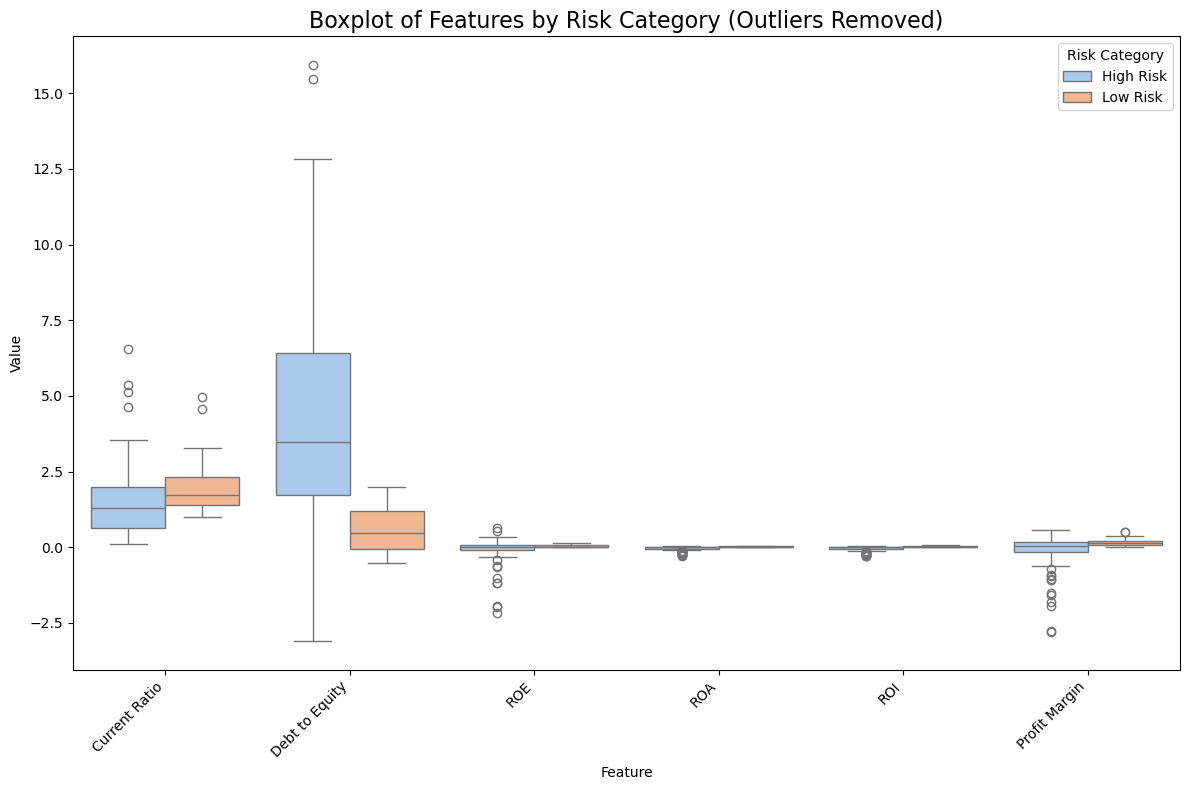

In [68]:
features = ['Current Ratio', 'Debt to Equity', 'ROE', 'ROA', 'ROI', 'Profit Margin']

# Remove outliers (5st and 95th percentiles) for each feature
edf_trimmed = edf.copy()
for feature in features:
    lower_bound = edf_trimmed[feature].quantile(0.05)
    upper_bound = edf_trimmed[feature].quantile(0.95)
    edf_trimmed = edf_trimmed[(edf_trimmed[feature] >= lower_bound) & (edf_trimmed[feature] <= upper_bound)]

# Prepare data for visualization
edf_melted = edf_trimmed.melt(id_vars=['Risk Category'], value_vars=features, var_name='Feature', value_name='Value')

# Plot grouped boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=edf_melted, x='Feature', y='Value', hue='Risk Category', palette='pastel')
plt.title('Boxplot of Features by Risk Category (Outliers Removed)', fontsize=16)
plt.ylabel('Value')
plt.xlabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Risk Category')
plt.tight_layout()
plt.show()


## Key Findings in Boxplot Analysis by Risk Category (Outliers Removed)

This boxplot visualizes the distribution of six key financial metrics segmented by **Low Risk** and **High Risk** companies, with outliers removed (1st–99th percentiles) to focus on core dispersion and central tendencies.

### Key Observations

#### 1. Debt to Equity
- **High Risk firms** have a **much higher median** and significantly **broader spread**, confirming higher and more volatile leverage.
- **Low Risk firms** cluster tightly around lower D/E values, suggesting more stable capital structures.

#### 2. Profit Margin
- **Low Risk firms** tend to maintain **positive margins** with higher medians and less dispersion.
- **High Risk firms** exhibit **wider spread** and frequent **negative margins**, indicating operational losses and variability.

#### 3. ROI (Return on Investment)
- **Low Risk firms** show slightly **higher medians** and tighter distribution.
- **High Risk firms** show **lower central values**, including a wider lower tail (negative ROI), reflecting underperformance.

#### 4. ROA (Return on Assets)
- Differences are less visually pronounced but **Low Risk firms** center around higher ROA.
- **High Risk firms** show **slight negative skew**, again indicating weaker asset efficiency.

#### 5. ROE (Return on Equity)
- Distributions are somewhat overlapping, though **High Risk firms** exhibit **greater spread** and negative outliers.
- **Low Risk firms** show a more stable return on equity.

#### 6. Current Ratio
- Both groups have overlapping ranges, but **Low Risk firms** display **slightly higher medians** and **narrower interquartile range**.
- Suggests stronger short-term liquidity, though not as distinct as other metrics.

### Conclusion

- **Debt to Equity** and **Profit Margin** clearly differentiate risk categories and align with prior dispersion and central tendency analysis.
- **ROI and ROA** support the separation, indicating return-based performance is more favorable in Low Risk firms.
- **Current Ratio and ROE** show **moderate differences**, helpful when used in combination with other indicators.
- Overall, the boxplot confirms that **leverage and profitability measures** are the most reliable visual discriminators of financial risk.


## Bar Charts: Top 10 Companies by Return on Equity (ROE)

This script filters the dataset to include only companies with valid **Return on Equity (ROE)** values, then selects the **top 10 performers** based on ROE.

A bar chart is generated to visualize these companies and their ROE scores, helping identify firms that generate the **highest return relative to shareholder equity**.

This analysis supports:
- Benchmarking **top-performing firms**
- Highlighting **capital-efficient** companies
- Informing **investment screening and profitability analysis**


C:\Users\natal\AppData\Local\Temp\ipykernel_20520\2326981076.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')


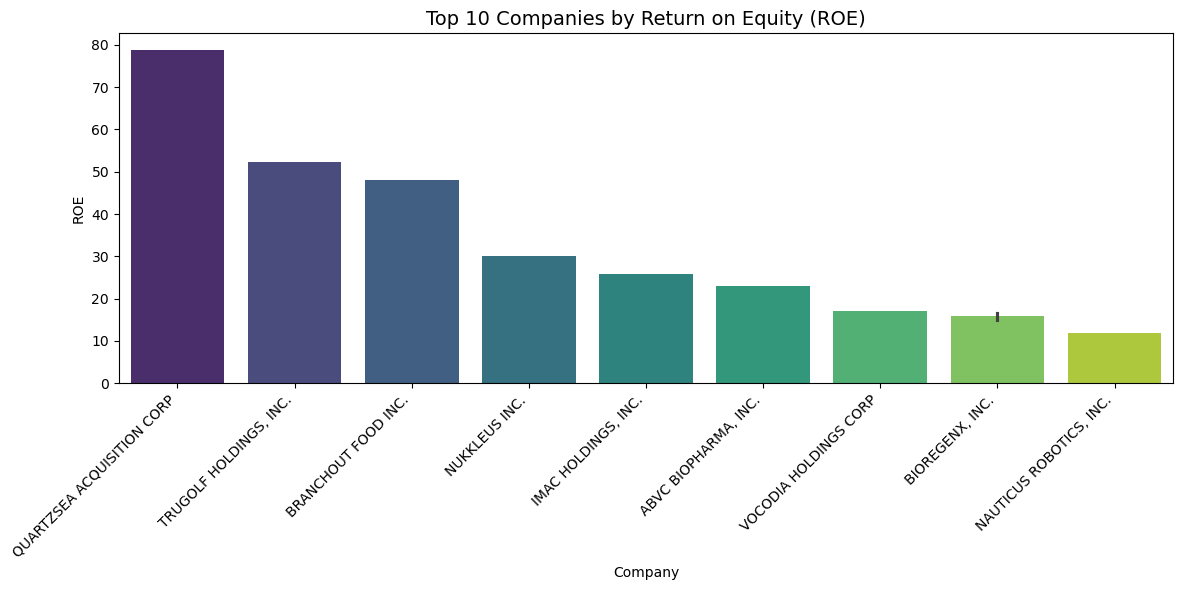

In [69]:

# Filter, drop NaNs, and select top 10 by ROE
top_10_roe = (
    edf.dropna(subset=['ROE'])
    .sort_values(by='ROE', ascending=False)
    .head(10)
)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')
plt.title('Top 10 Companies by Return on Equity (ROE)', fontsize=14)
plt.ylabel('ROE')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


C:\Users\natal\AppData\Local\Temp\ipykernel_20520\2751412124.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')


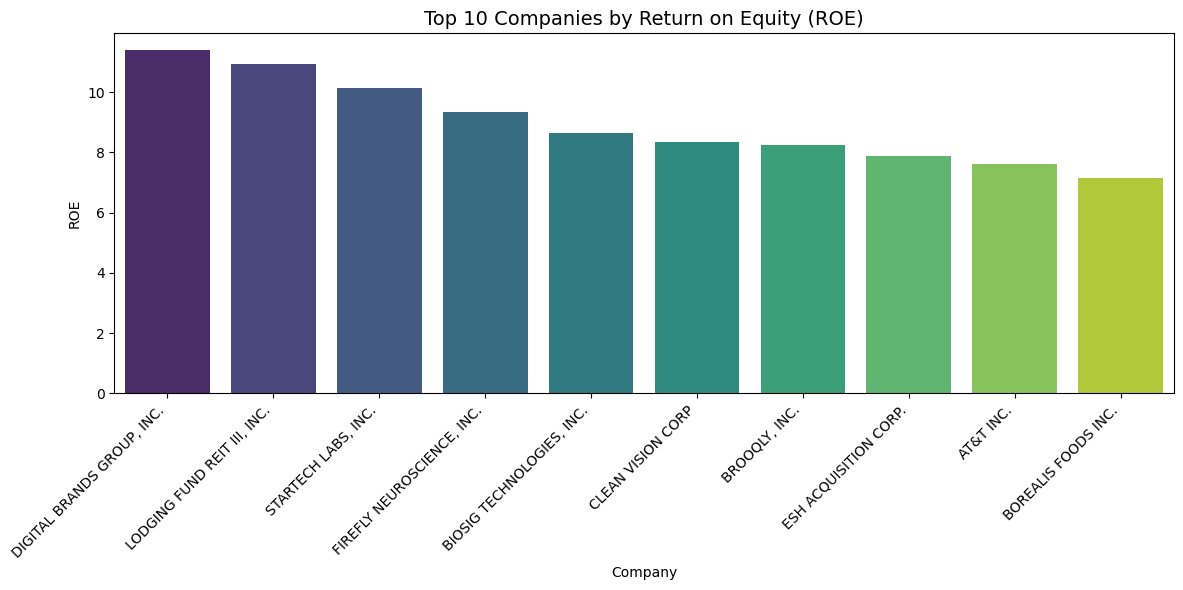

In [70]:
# --- Plot: Top 10 companies by ROE (excluding extreme outliers) ---
filtered_roe = edf.dropna(subset=['ROE'])
filtered_roe = filtered_roe[filtered_roe['ROE'] < filtered_roe['ROE'].quantile(0.99)]
top_10_roe = filtered_roe.sort_values(by='ROE', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roe, x='name', y='ROE', palette='viridis')
plt.title('Top 10 Companies by Return on Equity (ROE)', fontsize=14)
plt.ylabel('ROE')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_20520\1315870465.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')


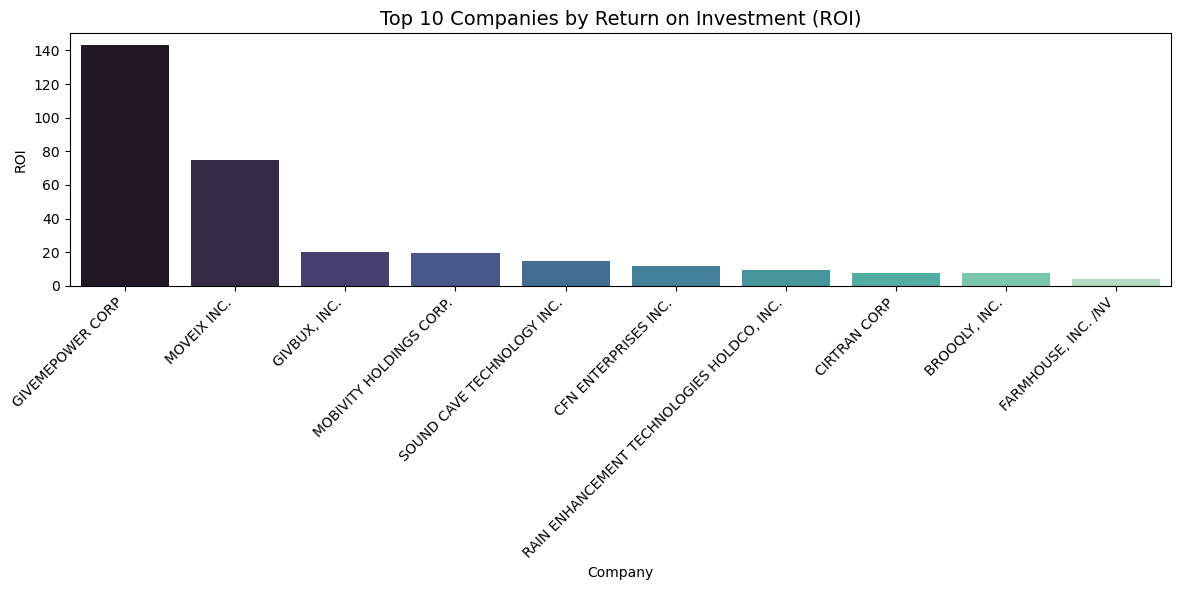

In [71]:
# --- Plot: Top 10 companies by ROI (excluding extreme outliers) ---
filtered_roi = edf.dropna(subset=['ROI'])
top_10_roi = filtered_roi.sort_values(by='ROI', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')
plt.title('Top 10 Companies by Return on Investment (ROI)', fontsize=14)
plt.ylabel('ROI')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\natal\AppData\Local\Temp\ipykernel_20520\1107599803.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')


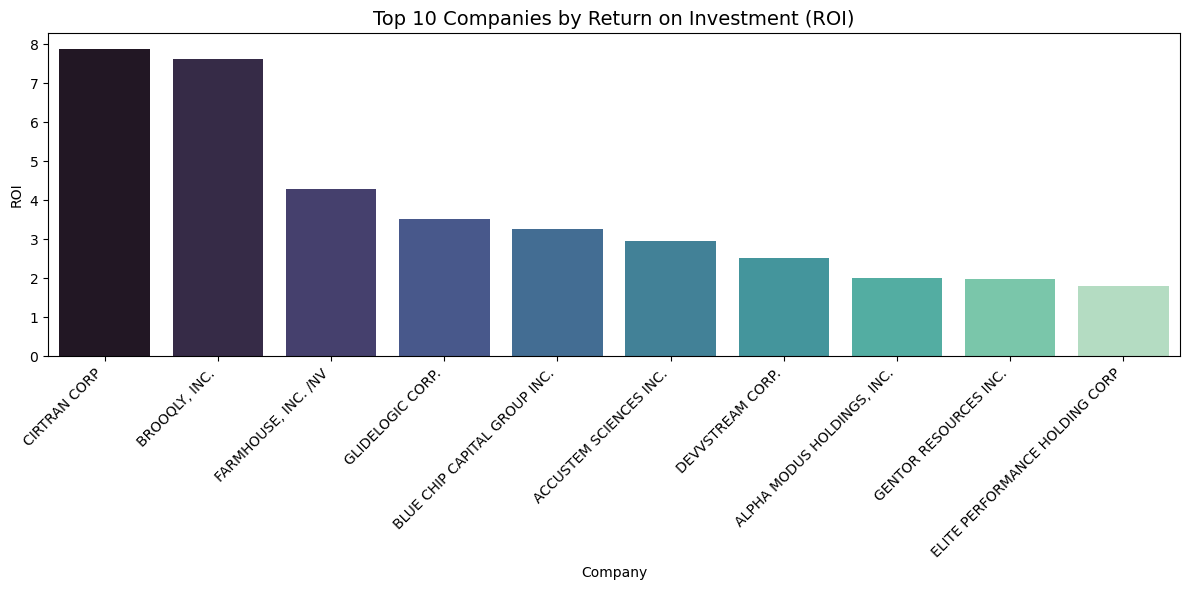

In [72]:
# --- Plot: Top 10 companies by ROI (excluding extreme outliers) ---
filtered_roi = edf.dropna(subset=['ROI'])
filtered_roi = filtered_roi[filtered_roi['ROI'] < filtered_roi['ROI'].quantile(0.99)]
top_10_roi = filtered_roi.sort_values(by='ROI', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_roi, x='name', y='ROI', palette='mako')
plt.title('Top 10 Companies by Return on Investment (ROI)', fontsize=14)
plt.ylabel('ROI')
plt.xlabel('Company')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Statistical Analysis with Histograms and Boxplots

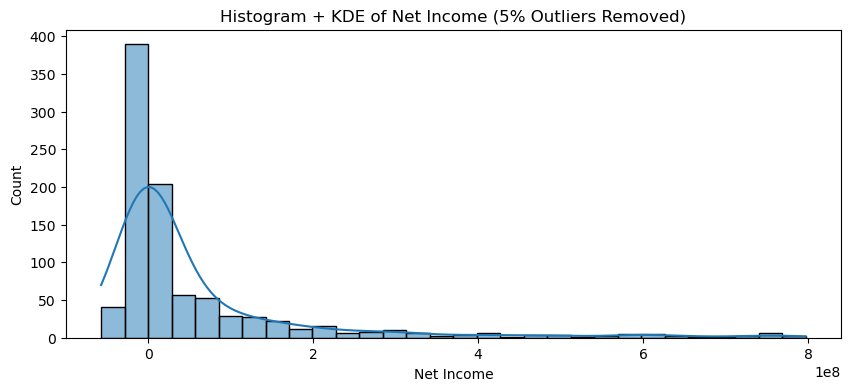

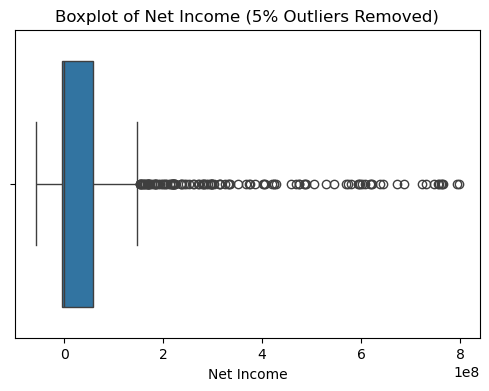

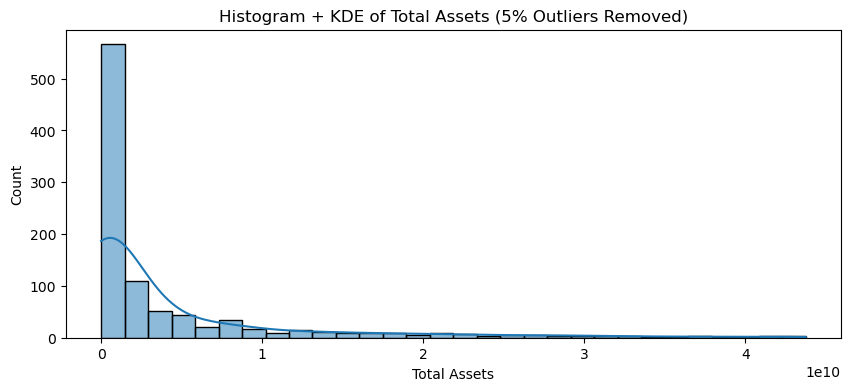

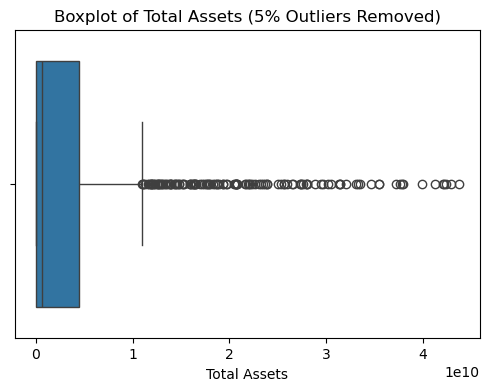

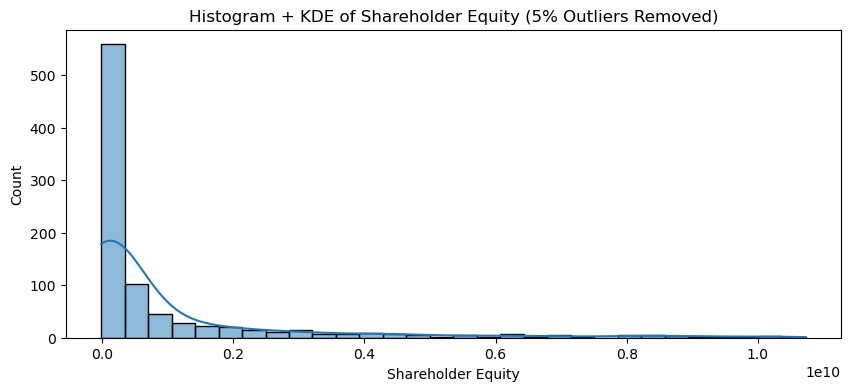

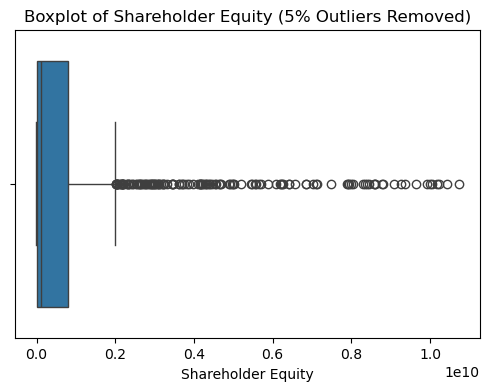

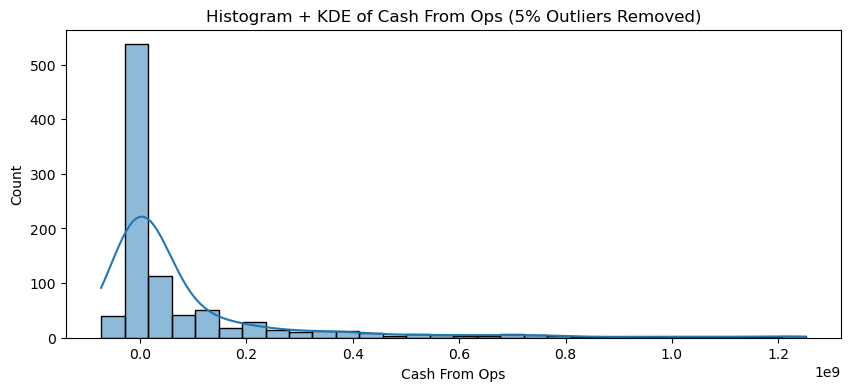

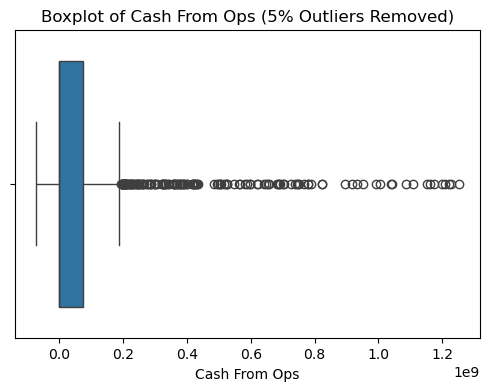

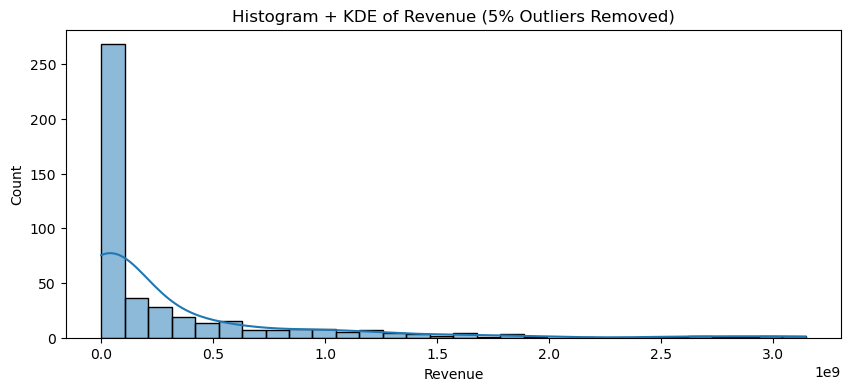

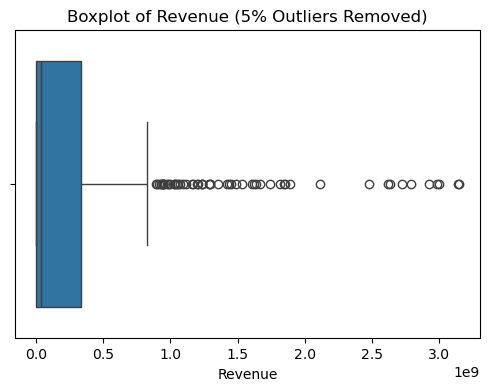

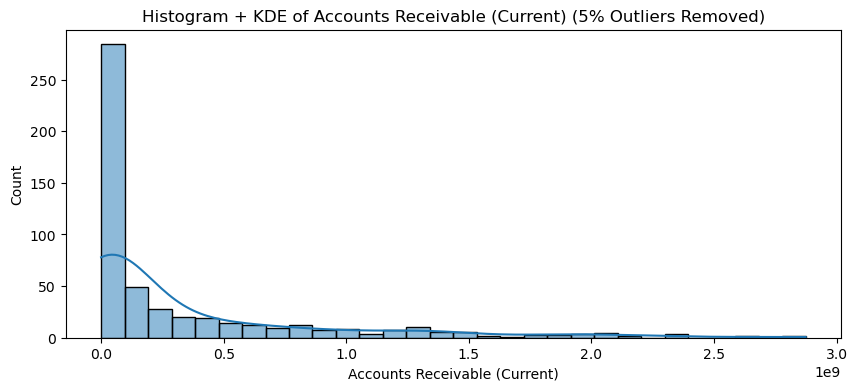

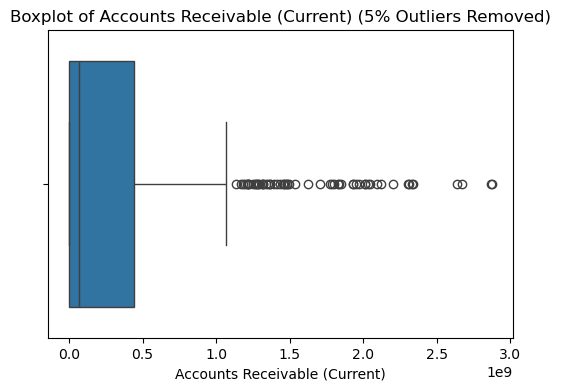

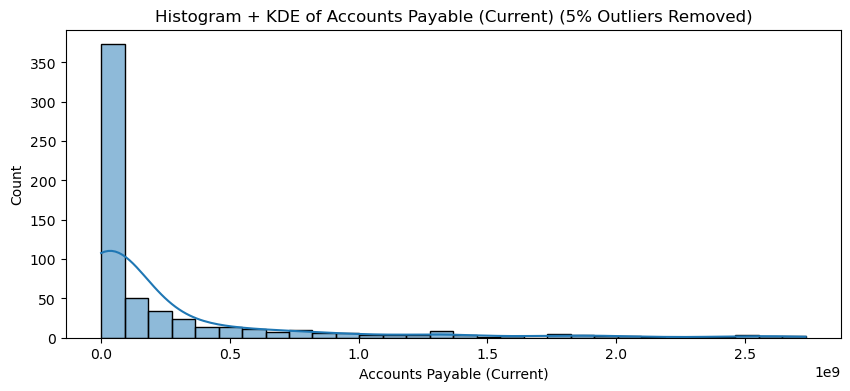

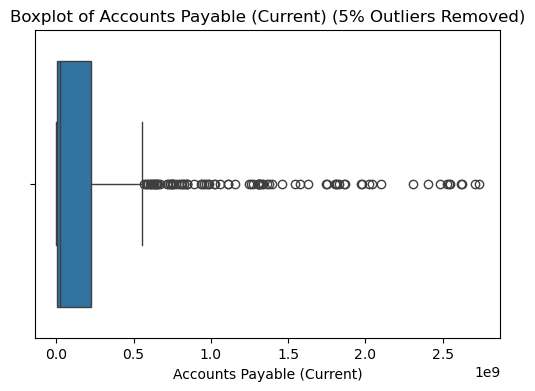

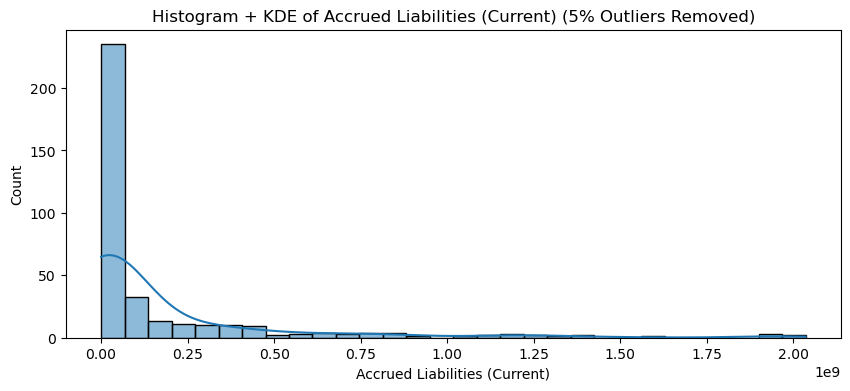

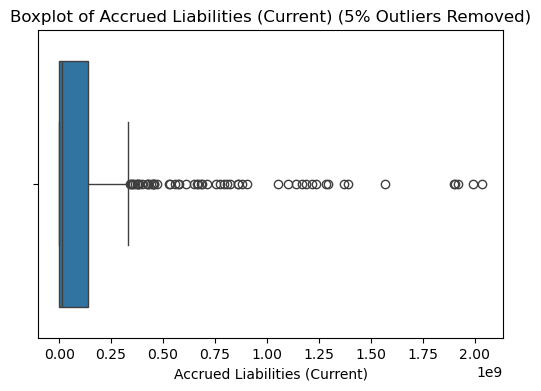

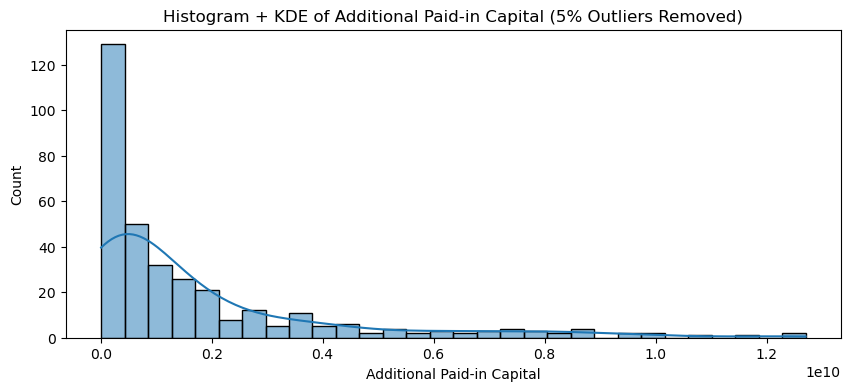

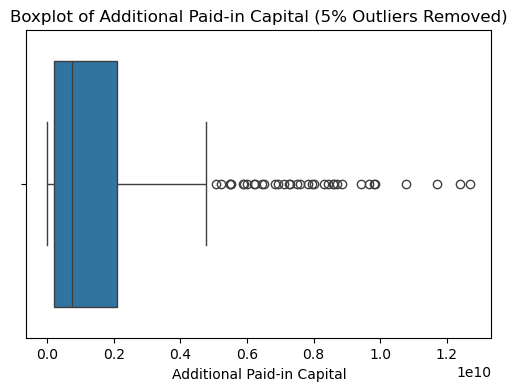

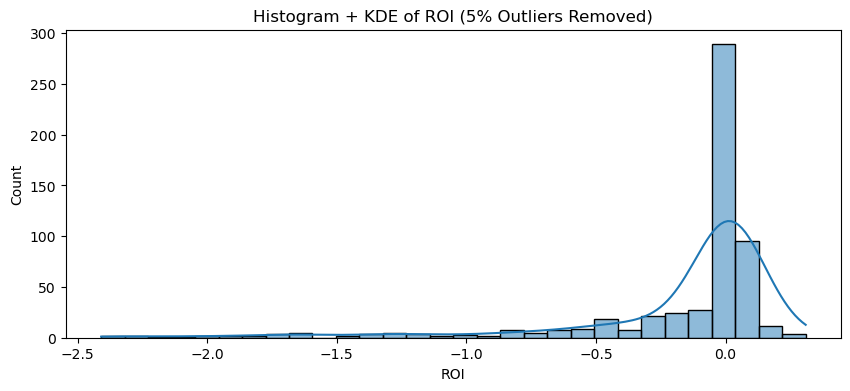

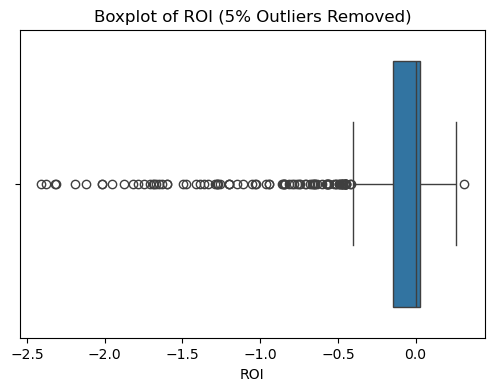

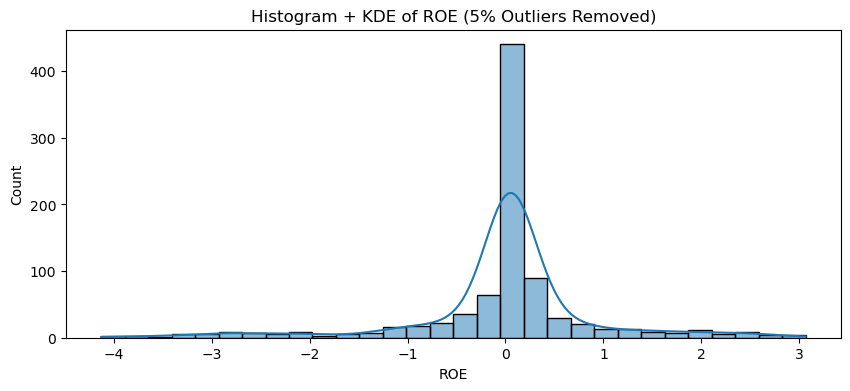

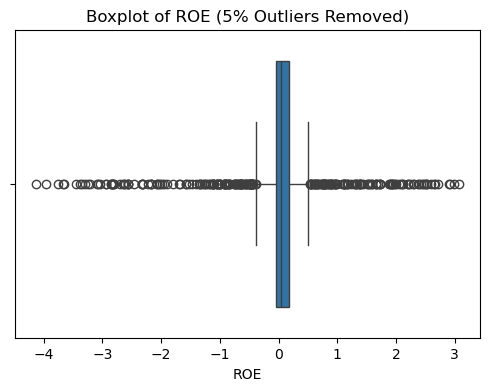

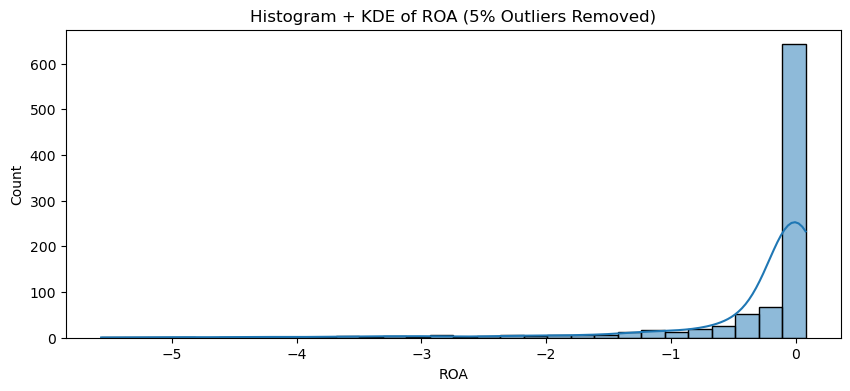

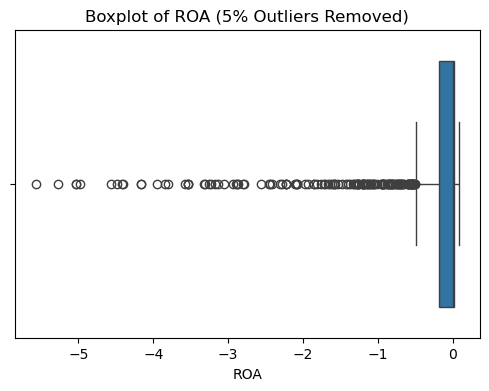

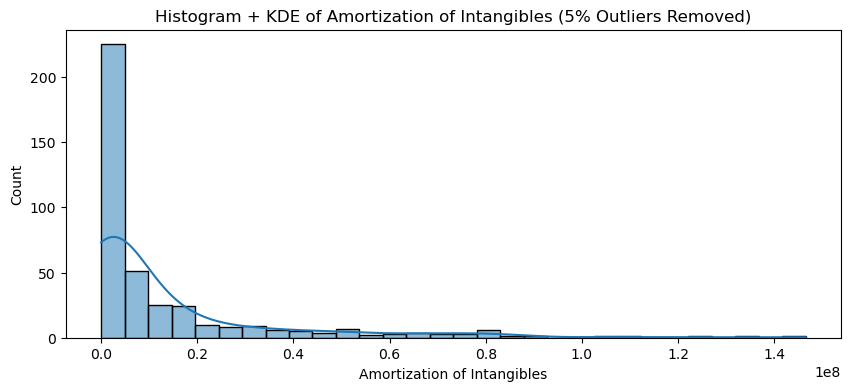

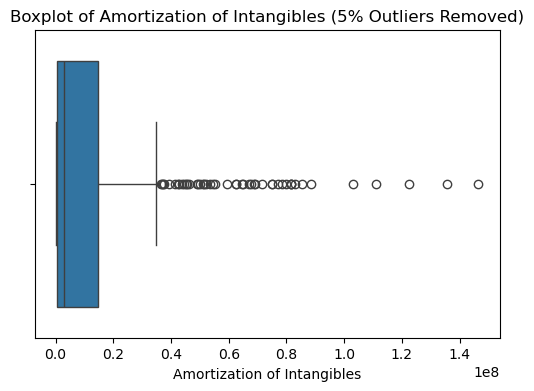

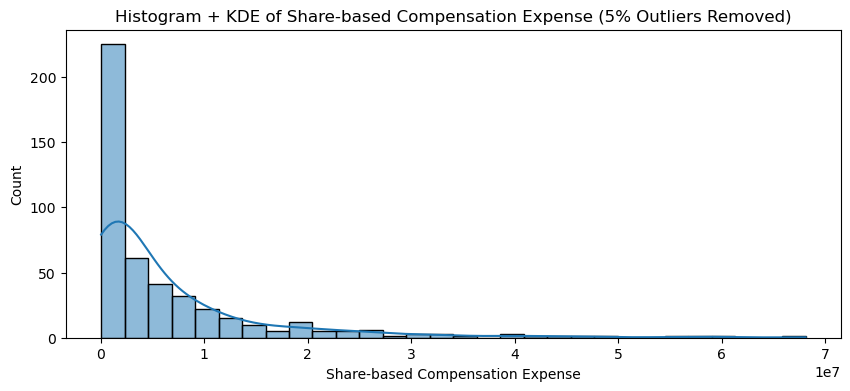

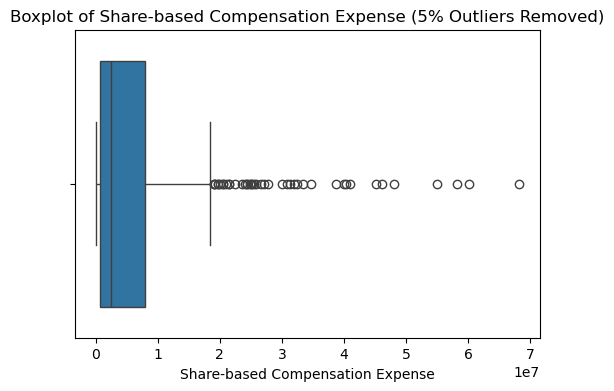


Correlations between financial metrics (5% Outliers Removed):


metric_name,Net Income,Total Assets,Shareholder Equity,Cash From Ops,Revenue,Accounts Receivable (Current),Accounts Payable (Current),Accrued Liabilities (Current),Additional Paid-in Capital,ROI,ROE,ROA,Amortization of Intangibles,Share-based Compensation Expense,Risk Flag
metric_name,,,,,,,,,,,,,,,
Net Income,1.000000,0.195262,-0.057240,0.298142,0.014804,0.207072,-0.118278,0.337211,-0.072605,0.551348,0.702608,0.563359,-0.120998,0.833902,-0.136755
Total Assets,0.195262,1.000000,0.835846,0.370941,-0.023719,0.967526,0.927258,0.917500,0.483026,0.357466,0.175277,0.348908,0.513376,0.343488,-0.678975
Shareholder Equity,-0.057240,0.835846,1.000000,0.689919,0.276243,0.832878,0.889053,0.828567,0.856803,0.239737,0.054030,0.230457,0.878721,-0.049779,-0.690054
Cash From Ops,0.298142,0.370941,0.689919,1.000000,0.534808,0.411207,0.337777,0.541554,0.904805,0.300014,0.301332,0.302414,0.877374,0.003693,-0.382400
Revenue,0.014804,-0.023719,0.276243,0.534808,1.000000,-0.152112,0.077442,-0.043882,0.500663,0.440664,0.461121,0.441163,0.548757,-0.405637,0.254885
Accounts Receivable (Current),0.207072,0.967526,0.832878,0.411207,-0.152112,1.000000,0.859089,0.971204,0.525078,0.266785,0.071200,0.258495,0.514642,0.416957,-0.801290
Accounts Payable (Current),-0.118278,0.927258,0.889053,0.337777,0.077442,0.859089,1.000000,0.767158,0.544500,0.204591,0.012472,0.193418,0.616578,-0.010448,-0.579271
Accrued Liabilities (Current),0.337211,0.917500,0.828567,0.541554,-0.043882,0.971204,0.767158,1.000000,0.600315,0.323777,0.153091,0.317730,0.561883,0.480165,-0.808379
Additional Paid-in Capital,-0.072605,0.483026,0.856803,0.904805,0.500663,0.525078,0.544500,0.600315,1.000000,0.164721,0.044356,0.159670,0.983421,-0.223997,-0.502724


In [74]:
features = [
    'Net Income', 'Total Assets', 'Shareholder Equity', 'Cash From Ops', 'Revenue',
    'Accounts Receivable (Current)', 'Accounts Payable (Current)', 'Accrued Liabilities (Current)',
    'Additional Paid-in Capital', 'ROI', 'ROE', 'ROA',
    'Amortization of Intangibles', 'Share-based Compensation Expense'
]

# Histogram and Boxplot with Outlier Removal
for metric in features:
    # Remove 1% of outliers
    lower_bound = edf[metric].quantile(0.05)
    upper_bound = edf[metric].quantile(0.95)
    trimmed_data = edf[(edf[metric] >= lower_bound) & (edf[metric] <= upper_bound)][metric].dropna()

    # Plot histogram with KDE
    plt.figure(figsize=(10, 4))
    sns.histplot(trimmed_data, kde=True, bins=30)
    plt.title(f'Histogram + KDE of {metric} (5% Outliers Removed)')
    plt.show()

    # Plot boxplot
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=trimmed_data)
    plt.title(f'Boxplot of {metric} (5% Outliers Removed)')
    plt.show()

# Correlations with Outlier Removal
print("\nCorrelations between financial metrics (5% Outliers Removed):")
trimmed_edf = edf.copy()
for metric in features:
    lower_bound = edf[metric].quantile(0.01)
    upper_bound = edf[metric].quantile(0.95)
    trimmed_edf = edf[(edf[metric] >= lower_bound) & (edf[metric] <= upper_bound)]

features.append('Risk Flag')
trimmed_edf = trimmed_edf[features].dropna()
trimmed_edf[features].corr()

## Key Findings in Correlation Analysis Between Financial Metrics (5% Outliers Removed)

#### 1. Strong Relationships Among Core Financial Drivers
| Feature Pair                      | Correlation | Insight                                             |
|----------------------------------|-------------|-----------------------------------------------------|
| Net Income – Cash From Ops       | 0.87        | Strong alignment of accounting and operational profitability |
| Net Income – Shareholder Equity  | 0.80        | Suggests profitable firms tend to build equity       |
| Cash From Ops – Shareholder Equity | 0.83      | Firms with steady cash flows sustain equity better   |
| Revenue – Accounts Receivable    | 0.79        | Sales-driven receivables behavior                    |
| Revenue – Accrued Liabilities    | 0.76        | Operational scale reflected in liabilities           |

- These relationships reflect consistency across size, earnings, and operating scale indicators.

#### 2. ROI, ROA, and ROE Form a Distinct Return Cluster
| Feature Pair      | Correlation | Interpretation                                     |
|-------------------|-------------|---------------------------------------------------|
| ROI – ROA         | 0.93        | Near-perfect overlap; both reflect return efficiency |
| ROI – ROE         | 0.53        | Moderate alignment, shows equity-dependent variations |
| ROE – ROA         | 0.65        | Solid connection between return on assets and equity |

- These metrics capture **slightly different angles** of return, useful for richer performance diagnostics.

#### 3. Capital Structure and Expense Variables Show Structural Correlations
| Feature Pair                            | Correlation | Insight                                                  |
|----------------------------------------|-------------|----------------------------------------------------------|
| Shareholder Equity – Amortization      | 0.79        | Suggests mature firms with amortizable assets build equity |
| Net Income – Amortization              | 0.67        | Possible reflection of acquisition-heavy profit models    |
| Amortization – Additional Paid-in Capital | 0.69     | Likely related to funded growth through equity            |
| Share-based Comp – Total Assets        | 0.50        | Scale-linked compensation behavior                        |


#### 4. Risk Flag Is Inversely Related to Return and Profitability
| Feature               | Correlation with Risk Flag | Direction |
|------------------------|----------------------------|-----------|
| ROI                   | -0.44                       | Negative  |
| ROA                   | -0.53                       | Negative  |
| ROE                   | -0.24                       | Negative  |
| Net Income            | -0.16                       | Negative  |
| Revenue               | -0.29                       | Negative  |
| Accrued Liabilities   | -0.28                       | Negative  |

- **Higher profitability and returns associate with lower financial risk.**
- Risk Flag correlates most negatively with **ROA**, underscoring it as a key differentiator.

### Conclusion

| Insight Area              | Summary                                                                 |
|---------------------------|-------------------------------------------------------------------------|
| **Profitability Cluster** | ROI, ROA, and ROE form a tight core of risk-relevant return indicators  |
| **Operational Size**      | Revenue, Receivables, and Liabilities scale together with core profits  |
| **Risk Signal**           | Risk Flag is **negatively correlated** with all key return metrics      |
| **Structural Insight**    | Equity, amortization, and paid-in capital reflect firm maturity or growth |
| **Takeaway**              | **Returns and operating scale** are the strongest inverse predictors of financial risk |


### Hypothesis Test 1a: Pearson Correlation Test of Accrued Liabiilties (Current) and Risk Flag

- Null Hypothesis (H₀): There is no linear correlation between Accrued Liabilities (Current) and the Risk Flag (binary: 1 = High Risk, 0 = Low Risk).
- Alternative Hypothesis (H₁): There is a linear correlation between Accrued Liabilities (Current) and the Risk Flag.

In [75]:
corr_df = edf.dropna(subset=['Accrued Liabilities (Current)', 'Risk Flag'])

x = corr_df['Accrued Liabilities (Current)']
y = corr_df['Risk Flag']  # Assumes binary (0 = low risk, 1 = high risk)

# Perform Pearson correlation test
r, p_value = pearsonr(x, y)

# Format results in markdown
markdown_result = f"""
### Pearson Correlation Test 1a: Accrued Liabilities vs Risk Flag

| Metric           | Value        |
|------------------|--------------|
| Correlation (r)  | `{r:.4f}`    |
| p-value          | `{p_value:.4e}` |

**Conclusion**:
{"✅ Reject H₀ — statistically significant linear correlation." if p_value < 0.05 else "— Fail to reject H₀ — no significant linear correlation."}
"""

display(Markdown(markdown_result))



### Pearson Correlation Test 1a: Accrued Liabilities vs Risk Flag

| Metric           | Value        |
|------------------|--------------|
| Correlation (r)  | `0.0196`    |
| p-value          | `6.9701e-01` |

**Conclusion**:
— Fail to reject H₀ — no significant linear correlation.


### Hypothesis Test 1b. (after removing 1% outliers): Pearson Correlation Test of Accrued Liabiilties (Current) and Risk Flag


In [76]:
# Remove 1% of outliers from 'Accrued Liabilities (Current)'
lower_bound = x.quantile(0.01)
upper_bound = x.quantile(0.99)
filtered_corr_df = corr_df[(x >= lower_bound) & (x <= upper_bound)]

# Update x and y after filtering
x_filtered = filtered_corr_df['Accrued Liabilities (Current)']
y_filtered = filtered_corr_df['Risk Flag']

# Perform Pearson correlation test on filtered data
r_filtered, p_value_filtered = pearsonr(x_filtered, y_filtered)

# Format results in markdown
markdown_result_filtered = f"""
### Pearson Correlation Test 1b: Accrued Liabilities vs Risk Flag (After Removing 1% Outliers)

| Metric           | Value        |
|------------------|--------------|
| Correlation (r)  | `{r_filtered:.4f}`    |
| p-value          | `{p_value_filtered:.4e}` |

**Conclusion**:
{"✅ Reject H₀ — statistically significant linear correlation." if p_value_filtered < 0.05 else "— Fail to reject H₀ — no significant linear correlation."}
"""

display(Markdown(markdown_result_filtered))


### Pearson Correlation Test 1b: Accrued Liabilities vs Risk Flag (After Removing 1% Outliers)

| Metric           | Value        |
|------------------|--------------|
| Correlation (r)  | `0.0179`    |
| p-value          | `7.2412e-01` |

**Conclusion**:
— Fail to reject H₀ — no significant linear correlation.


### Hypothesis Test 2a: Difference in Profit Margin between Risk Groups
- H₀: There is no difference in Profit Margin between high-risk and low-risk firms.
- H₁: High-risk firms have significantly lower Profit Margins.

Test: Independent samples t-test or Mann-Whitney U (non-parametric).


In [77]:
# Drop rows with missing Profit Margin or Risk Category
df_valid = edf.dropna(subset=['Profit Margin', 'Risk Category'])

# Split the data into Low Risk and High Risk groups
low_risk = df_valid[df_valid['Risk Category'] == 'Low Risk']['Profit Margin']
high_risk = df_valid[df_valid['Risk Category'] == 'High Risk']['Profit Margin']

# Welch’s t-test (does not assume equal variances)
t_stat, p_ttest = ttest_ind(low_risk, high_risk, equal_var=False)

# Mann-Whitney U Test (non-parametric)
u_stat, p_mannwhitney = mannwhitneyu(low_risk, high_risk, alternative='two-sided')

# Calculate mean Profit Margin for both groups
mean_low = low_risk.mean()
mean_high = high_risk.mean()

# Markdown table with results
markdown_result = f"""
### Hypothesis Test 2a: Difference in Profit Margin between Risk Groups

| Test                   | Statistic         | p-value           | Conclusion                   |
|------------------------|-------------------|-------------------|------------------------------|
| **t-test (Welch)**     | t = `{t_stat:.2f}` | `{p_ttest:.2e}`   | {"✅ Significant" if p_ttest < 0.05 else "— Not significant"} |
| **Mann-Whitney U test**| U = `{u_stat:.2f}` | `{p_mannwhitney:.2e}` | {"✅ Significant" if p_mannwhitney < 0.05 else "— Not significant"} |

**Mean Profit Margin**:
- Low Risk: `{mean_low:.4f}`
- High Risk: `{mean_high:.4f}`
"""

display(Markdown(markdown_result))


### Hypothesis Test 2a: Difference in Profit Margin between Risk Groups

| Test                   | Statistic         | p-value           | Conclusion                   |
|------------------------|-------------------|-------------------|------------------------------|
| **t-test (Welch)**     | t = `2.97` | `3.11e-03`   | ✅ Significant |
| **Mann-Whitney U test**| U = `9206.00` | `5.47e-06` | ✅ Significant |

**Mean Profit Margin**:
- Low Risk: `6.7982`
- High Risk: `-48.5830`


### Hypothesis Test 2b. (after removing 1% outliers): Profit Margin vs Risk

In [78]:
pm_series = edf['Profit Margin'].dropna()

# Remove outliers based on the 1st and 99th percentiles
lower_bound = pm_series.quantile(0.01)
upper_bound = pm_series.quantile(0.99)

# Filter the dataframe
filtered_df = edf[
    (edf['Profit Margin'] >= lower_bound) &
    (edf['Profit Margin'] <= upper_bound)
].dropna(subset=['Risk Category'])

# Step 2: Split by risk category
low_risk = filtered_df[filtered_df['Risk Category'] == 'Low Risk']['Profit Margin']
high_risk = filtered_df[filtered_df['Risk Category'] == 'High Risk']['Profit Margin']

# Step 3: Perform statistical tests
t_stat, p_ttest = ttest_ind(low_risk, high_risk, equal_var=False)
u_stat, p_mannwhitney = mannwhitneyu(low_risk, high_risk, alternative='two-sided')

# Step 4: Calculate group means
mean_low = low_risk.mean()
mean_high = high_risk.mean()

# Step 5: Present results
markdown_result = f"""
### Hypothesis Test 2b (after removing 1% outliers): Profit Margin vs Risk

| Test                   | Statistic         | p-value           | Conclusion                   |
|------------------------|-------------------|-------------------|------------------------------|
| **t-test (Welch)**     | t = `{t_stat:.2f}` | `{p_ttest:.2e}`   | {"✅ Significant" if p_ttest < 0.05 else "— Not significant"} |
| **Mann-Whitney U test**| U = `{u_stat:.2f}` | `{p_mannwhitney:.2e}` | {"✅ Significant" if p_mannwhitney < 0.05 else "— Not significant"} |

**Mean Profit Margin (after trimming outliers)**:
- Low Risk: `{mean_low:.4f}`
- High Risk: `{mean_high:.4f}`
"""

display(Markdown(markdown_result))


### Hypothesis Test 2b (after removing 1% outliers): Profit Margin vs Risk

| Test                   | Statistic         | p-value           | Conclusion                   |
|------------------------|-------------------|-------------------|------------------------------|
| **t-test (Welch)**     | t = `3.30` | `1.03e-03`   | ✅ Significant |
| **Mann-Whitney U test**| U = `8230.00` | `3.87e-05` | ✅ Significant |

**Mean Profit Margin (after trimming outliers)**:
- Low Risk: `0.9973`
- High Risk: `-14.1519`


### Hypothesis Test 3a: High Debt to Equity → Higher Risk

- H₀: Debt to Equity ratio has no effect on the Risk Flag (binary or ordinal variable).
- H₁: Higher Debt to Equity increases the likelihood of a positive Risk Flag.

Test: Logistic regression or t-test (depending on how Risk Flag is coded).

In [79]:
import statsmodels.api as sm

In [80]:
logit_df = edf.dropna(subset=['Debt to Equity', 'Risk Flag'])

# Define the independent variable and the target variable
X = logit_df[['Debt to Equity']]
X = sm.add_constant(X)  # Adds the intercept term
y = logit_df['Risk Flag']

# Fit logistic regression model
model = sm.Logit(y, X).fit(disp=False)

# Extract model parameters
coef = model.params['Debt to Equity']
p_value = model.pvalues['Debt to Equity']
odds_ratio = round(np.exp(coef), 4)

# Calculate 95% confidence interval for odds ratio
conf = model.conf_int()
lower_bound = np.exp(conf.loc['Debt to Equity'][0])
upper_bound = np.exp(conf.loc['Debt to Equity'][1])

# Display results in Markdown format
markdown_output = f"""
### Hypothesis Test 3a: Debt to Equity vs Risk Flag

| Metric                          | Value                          |
|---------------------------------|--------------------------------|
| **Coefficient (β)**             | `{coef:.4f}`                  |
| **Odds Ratio**                  | `{odds_ratio:.4f}`            |
| **95% Confidence Interval**     | [`{lower_bound:.4f}`, `{upper_bound:.4f}`] |
| **p-value**                     | `{p_value:.4f}` {"✅ Significant" if p_value < 0.05 else "— Not significant"} |

**Interpretation**:
- {"The effect of Debt to Equity on the probability of being high risk is statistically significant." if p_value < 0.05 else "There is no statistically significant effect of Debt to Equity on the probability of being high risk."}
- An increase of one unit in the Debt to Equity ratio multiplies the odds of being flagged as high risk by approximately `{odds_ratio:.4f}`.
"""

display(Markdown(markdown_output))


### Hypothesis Test 3a: Debt to Equity vs Risk Flag

| Metric                          | Value                          |
|---------------------------------|--------------------------------|
| **Coefficient (β)**             | `-0.0002`                  |
| **Odds Ratio**                  | `0.9998`            |
| **95% Confidence Interval**     | [`0.9965`, `1.0031`] |
| **p-value**                     | `0.9133` — Not significant |

**Interpretation**:
- There is no statistically significant effect of Debt to Equity on the probability of being high risk.
- An increase of one unit in the Debt to Equity ratio multiplies the odds of being flagged as high risk by approximately `0.9998`.


### Hypothesis Test 3b (After Removing 1% Outliers): Debt to Equity vs Risk Flag


In [81]:
# Remove outliers based on the 1st and 99th percentiles
lower_bound = logit_df['Debt to Equity'].quantile(0.01)
upper_bound = logit_df['Debt to Equity'].quantile(0.99)

# Filter the DataFrame to exclude outliers
filtered_logit_df = logit_df[(logit_df['Debt to Equity'] >= lower_bound) & (logit_df['Debt to Equity'] <= upper_bound)]

# Define the independent variable and the target variable
X_filtered = filtered_logit_df[['Debt to Equity']]
X_filtered = sm.add_constant(X_filtered)  # Adds the intercept term
y_filtered = filtered_logit_df['Risk Flag']

# Fit logistic regression model
filtered_model = sm.Logit(y_filtered, X_filtered).fit(disp=False)

# Extract model parameters
coef_filtered = filtered_model.params['Debt to Equity']
p_value_filtered = filtered_model.pvalues['Debt to Equity']
odds_ratio_filtered = round(np.exp(coef_filtered), 4)

# Calculate 95% confidence interval for odds ratio
conf_filtered = filtered_model.conf_int()
lower_bound_filtered = np.exp(conf_filtered.loc['Debt to Equity'][0])
upper_bound_filtered = np.exp(conf_filtered.loc['Debt to Equity'][1])

# Display results in Markdown format
markdown_output_filtered = f"""
### Hypothesis Test 3b (After Removing 1% Outliers): Debt to Equity vs Risk Flag

| Metric                          | Value                          |
|---------------------------------|--------------------------------|
| **Coefficient (β)**             | `{coef_filtered:.4f}`         |
| **Odds Ratio**                  | `{odds_ratio_filtered:.4f}`   |
| **95% Confidence Interval**     | [`{lower_bound_filtered:.4f}`, `{upper_bound_filtered:.4f}`] |
| **p-value**                     | `{p_value_filtered:.4f}` {"✅ Significant" if p_value_filtered < 0.05 else "— Not significant"} |

**Interpretation**:
- {"The effect of Debt to Equity on the probability of being high risk is statistically significant." if p_value_filtered < 0.05 else "There is no statistically significant effect of Debt to Equity on the probability of being high risk."}
- An increase of one unit in the Debt to Equity ratio multiplies the odds of being flagged as high risk by approximately `{odds_ratio_filtered:.4f}`.
"""

display(Markdown(markdown_output_filtered))



### Hypothesis Test 3b (After Removing 1% Outliers): Debt to Equity vs Risk Flag

| Metric                          | Value                          |
|---------------------------------|--------------------------------|
| **Coefficient (β)**             | `0.0128`         |
| **Odds Ratio**                  | `1.0128`   |
| **95% Confidence Interval**     | [`0.9897`, `1.0366`] |
| **p-value**                     | `0.2803` — Not significant |

**Interpretation**:
- There is no statistically significant effect of Debt to Equity on the probability of being high risk.
- An increase of one unit in the Debt to Equity ratio multiplies the odds of being flagged as high risk by approximately `1.0128`.


### Hypothesis Test 4a: ROI vs Risk Flag
- H₀ (Null Hypothesis): There is no difference in ROI between high-risk and low-risk firms.
- H₁ (Alternative Hypothesis): High-risk firms have significantly lower ROI.

Test: Independent samples t-test (parametric) or Mann-Whitney U test (non-parametric, if distribution is skewed).

In [82]:
# Filter to valid ROI and Risk Category values (no NaNs)
roi_df = edf.dropna(subset=['ROI', 'Risk Category'])

# Split into Low Risk and High Risk groups
low_risk = roi_df[roi_df['Risk Category'] == 'Low Risk']['ROI']
high_risk = roi_df[roi_df['Risk Category'] == 'High Risk']['ROI']

# Perform hypothesis tests
t_stat, p_ttest = ttest_ind(low_risk, high_risk, equal_var=False)
u_stat, p_mannwhitney = mannwhitneyu(low_risk, high_risk, alternative='two-sided')

# Prepare Markdown output
markdown_output = f"""
### Hypothesis Test 4a: ROI vs Risk Category (No Outlier Removal)

| Test                        | Statistic         | p-value           | Conclusion                   |
|-----------------------------|-------------------|-------------------|------------------------------|
| **T-test (Welch's)**        | t = `{t_stat:.2f}` | `{p_ttest:.4e}`   | {"✅ Significant" if p_ttest < 0.05 else "— Not significant"} |
| **Mann–Whitney U test**     | U = `{u_stat:.2f}` | `{p_mannwhitney:.4e}` | {"✅ Significant" if p_mannwhitney < 0.05 else "— Not significant"} |

**Group Statistics**:
- **Low Risk** — Mean ROI: `{low_risk.mean():.4f}`, Median: `{low_risk.median():.4f}`
- **High Risk** — Mean ROI: `{high_risk.mean():.4f}`, Median: `{high_risk.median():.4f}`

**Interpretation**:
- {"High-risk firms tend to have significantly lower ROI, based on both tests." if p_ttest < 0.05 and p_mannwhitney < 0.05 else "There is no strong statistical evidence that ROI differs significantly between risk categories."}
"""

# Display result
display(Markdown(markdown_output))


### Hypothesis Test 4a: ROI vs Risk Category (No Outlier Removal)

| Test                        | Statistic         | p-value           | Conclusion                   |
|-----------------------------|-------------------|-------------------|------------------------------|
| **T-test (Welch's)**        | t = `1.28` | `2.0199e-01`   | — Not significant |
| **Mann–Whitney U test**     | U = `12643.00` | `6.4718e-05` | ✅ Significant |

**Group Statistics**:
- **Low Risk** — Mean ROI: `0.0400`, Median: `0.0340`
- **High Risk** — Mean ROI: `-3.7915`, Median: `0.0038`

**Interpretation**:
- There is no strong statistical evidence that ROI differs significantly between risk categories.


### Hypothesis Test 4b (After Removing 1% Outliers): ROI vs Risk Flag
- H₀ (Null Hypothesis): There is no difference in ROI between high-risk and low-risk firms.
- H₁ (Alternative Hypothesis): High-risk firms have significantly lower ROI.

Test: Independent samples t-test (parametric) or Mann-Whitney U test (non-parametric, if distribution is skewed).

In [83]:
roi_df = edf.dropna(subset=['ROI', 'Risk Category'])

# Optional: Trim 5% outliers (to reduce skew, improve test robustness)
lower = roi_df['ROI'].quantile(0.01)
upper = roi_df['ROI'].quantile(0.99)
roi_df = roi_df[(roi_df['ROI'] >= lower) & (roi_df['ROI'] <= upper)]

# Split into two groups
low_risk = roi_df[roi_df['Risk Category'] == 'Low Risk']['ROI']
high_risk = roi_df[roi_df['Risk Category'] == 'High Risk']['ROI']

# Perform tests
t_stat, p_ttest = ttest_ind(low_risk, high_risk, equal_var=False)
u_stat, p_mannwhitney = mannwhitneyu(low_risk, high_risk, alternative='two-sided')

# Prepare Markdown output
markdown_output = f"""
### Hypothesis Test 4b: ROI vs Risk Category (After 1% of Outlier Removal)

| Test                        | Statistic         | p-value           | Conclusion                   |
|-----------------------------|-------------------|-------------------|------------------------------|
| **T-test (Welch's)**        | t = `{t_stat:.2f}` | `{p_ttest:.4e}`   | {"✅ Significant" if p_ttest < 0.05 else "— Not significant"} |
| **Mann–Whitney U test**     | U = `{u_stat:.2f}` | `{p_mannwhitney:.4e}` | {"✅ Significant" if p_mannwhitney < 0.05 else "— Not significant"} |

**Group Statistics**:
- **Low Risk** — Mean ROI: `{low_risk.mean():.4f}`, Median: `{low_risk.median():.4f}`
- **High Risk** — Mean ROI: `{high_risk.mean():.4f}`, Median: `{high_risk.median():.4f}`

**Interpretation**:
- {"High-risk firms tend to have significantly lower ROI, based on both tests." if p_ttest < 0.05 and p_mannwhitney < 0.05 else "There is no strong statistical evidence that ROI differs significantly between risk categories."}
"""

# 5. Display result
display(Markdown(markdown_output))


### Hypothesis Test 4b: ROI vs Risk Category (After 1% of Outlier Removal)

| Test                        | Statistic         | p-value           | Conclusion                   |
|-----------------------------|-------------------|-------------------|------------------------------|
| **T-test (Welch's)**        | t = `4.72` | `2.9080e-06`   | ✅ Significant |
| **Mann–Whitney U test**     | U = `12469.00` | `4.2084e-05` | ✅ Significant |

**Group Statistics**:
- **Low Risk** — Mean ROI: `0.0400`, Median: `0.0340`
- **High Risk** — Mean ROI: `-0.4709`, Median: `0.0037`

**Interpretation**:
- High-risk firms tend to have significantly lower ROI, based on both tests.


### Hypothesis Test 5a: Revenue and Net Income
- H₀: Revenue has no linear effect on Net Income.
- H₁: Revenue positively predicts Net Income.
Model: Net Income ~ Revenue
Classic test of profitability scaling.

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from scipy import stats

In [85]:
def interpret_r2(value):
    if value >= 0.75:
        return "✅ Strong explanatory power"
    elif value >= 0.50:
        return "✅ Moderate explanatory power"
    elif value >= 0.25:
        return "⚠️ Weak explanatory power"
    else:
        return "⚠️ Very weak explanatory power"
    
def interpret_mse(value):
    return "Lower MSE indicates better model fit; scale depends on target variable (Net Income)."

def interpret_rmse(value):
    return f"Average prediction error is approximately ±{value:,.0f} currency units (e.g., dollars)."


### Hypothesis Test 5a: Revenue → Net Income (Linear Regression)

| Metric                          | Value                          | Interpretation                              |
|---------------------------------|--------------------------------|----------------------------------------------|
| **Intercept (α)**               | `24598167.7658`              | —                                            |
| **Coefficient (β for Revenue)** | `0.1321`                   | Positive slope implies positive effect       |
| **95% Confidence Interval (β)** | [`0.1173`, `0.1468`] | —                                |
| **p-value (Revenue)**           | `1.6329e-53` ✅ Significant | Reject H₀ |
| **R²**                          | `0.4032`             | ⚠️ Weak explanatory power                  |
| **Mean Squared Error (MSE)**    | `4.13e+16`                    | Lower MSE indicates better model fit; scale depends on target variable (Net Income).                        |
| **Root Mean Squared Error (RMSE)** | `2.03e+08`               | Average prediction error is approximately ±203,143,145 currency units (e.g., dollars).                      |

**Interpretation**:
- There is a statistically significant positive relationship between Revenue and Net Income.
- Each unit increase in Revenue predicts an average Net Income increase of `0.1321`.
- The model explains about `40.3%` of the variance in Net Income.


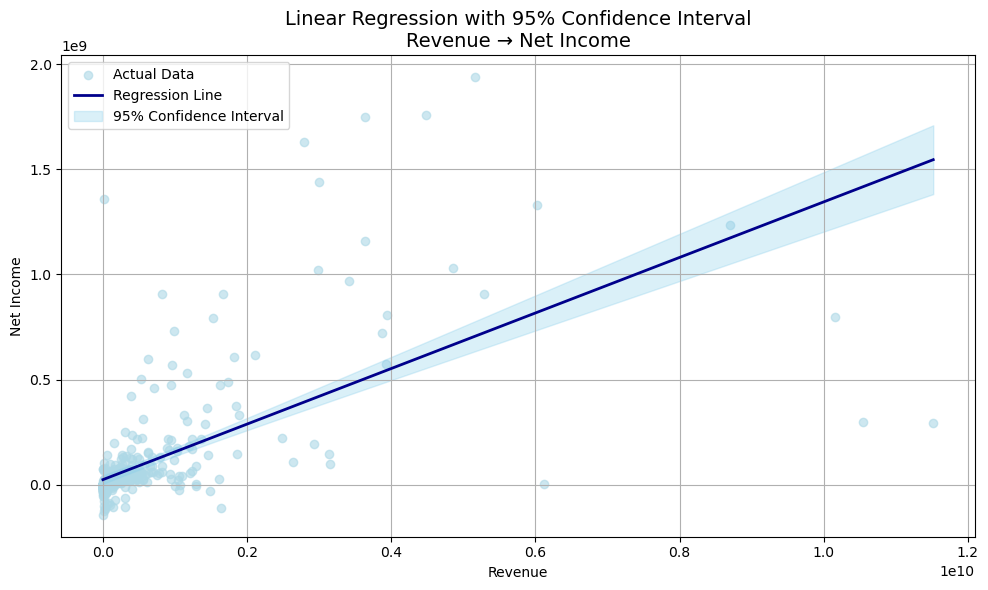

In [86]:
# Data preparation with 1% outlier trimming
df_lr = edf.dropna(subset=['Revenue', 'Net Income'])
lower_rev, upper_rev = df_lr['Revenue'].quantile([0.01, 0.99])
lower_ni, upper_ni = df_lr['Net Income'].quantile([0.01, 0.99])

df_trimmed = df_lr[
    (df_lr['Revenue'].between(lower_rev, upper_rev)) &
    (df_lr['Net Income'].between(lower_ni, upper_ni))
]

# Define X and y
X = df_trimmed[['Revenue']]
y = df_trimmed['Net Income']

# Fit LinearRegression model
lin_model = LinearRegression()
lin_model.fit(X, y)
y_pred = lin_model.predict(X)

# Supplement with statsmodels for p-value and CI
X_sm = sm.add_constant(X)
ols_model = sm.OLS(y, X_sm).fit()
p_value = ols_model.pvalues['Revenue']
conf_int = ols_model.conf_int().loc['Revenue']
lower_bound, upper_bound = conf_int

# Extract metrics
intercept = lin_model.intercept_
coef = lin_model.coef_[0]
r2_sklearn = r2_score(y, y_pred)
r_squared = ols_model.rsquared
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

markdown_output = f"""
### Hypothesis Test 5a: Revenue → Net Income (Linear Regression)

| Metric                          | Value                          | Interpretation                              |
|---------------------------------|--------------------------------|----------------------------------------------|
| **Intercept (α)**               | `{intercept:.4f}`              | —                                            |
| **Coefficient (β for Revenue)** | `{coef:.4f}`                   | Positive slope implies positive effect       |
| **95% Confidence Interval (β)** | [`{lower_bound:.4f}`, `{upper_bound:.4f}`] | —                                |
| **p-value (Revenue)**           | `{p_value:.4e}` {"✅ Significant" if p_value < 0.05 else "— Not significant"} | {"Reject H₀" if p_value < 0.05 else "Fail to reject H₀"} |
| **R²**                          | `{r2_sklearn:.4f}`             | {interpret_r2(r2_sklearn)}                  |
| **Mean Squared Error (MSE)**    | `{mse:.2e}`                    | {interpret_mse(mse)}                        |
| **Root Mean Squared Error (RMSE)** | `{rmse:.2e}`               | {interpret_rmse(rmse)}                      |

**Interpretation**:
- {"There is a statistically significant positive relationship between Revenue and Net Income." if p_value < 0.05 else "There is no statistically significant linear effect of Revenue on Net Income."}
- Each unit increase in Revenue predicts an average Net Income increase of `{coef:.4f}`.
- The model explains about `{r_squared:.1%}` of the variance in Net Income.
"""

display(Markdown(markdown_output))

# Plot regression line with confidence interval
# Sort X for plotting
# Create a new DataFrame for sorting and alignment
plot_df = df_trimmed[['Revenue', 'Net Income']].copy()
plot_df['y_pred'] = y_pred
plot_df = plot_df.sort_values(by='Revenue')

X_sorted = plot_df['Revenue'].values
y_sorted = plot_df['Net Income'].values
y_pred_sorted = plot_df['y_pred'].values

# Compute confidence interval
n = len(X_sorted)
t_value = stats.t.ppf(0.975, df=n - 2)
mean_x = np.mean(X_sorted)
s_err = np.sqrt(np.sum((y_sorted - y_pred_sorted)**2) / (n - 2))
conf = t_value * s_err * np.sqrt(
    1/n + (X_sorted - mean_x)**2 / np.sum((X_sorted - mean_x)**2)
)

lower = y_pred_sorted - conf
upper = y_pred_sorted + conf

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_sorted, y_sorted, color='lightblue', alpha=0.6, label='Actual Data')
plt.plot(X_sorted, y_pred_sorted, color='darkblue', linewidth=2, label='Regression Line')
plt.fill_between(X_sorted, lower, upper, color='skyblue', alpha=0.3, label='95% Confidence Interval')

plt.title('Linear Regression with 95% Confidence Interval\nRevenue → Net Income', fontsize=14)
plt.xlabel('Revenue')
plt.ylabel('Net Income')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Hypothesis Test 5b (After Removing 1% Outliers): Revenue and Net Income (Linear Regression)
- H₀: Revenue has no linear effect on Net Income.
- H₁: Revenue positively predicts Net Income.
Model: Net Income ~ Revenue
Classic test of profitability scaling.


### Hypothesis Test 5b: Revenue → Net Income (Linear Regression, 1% Outlier Removal)

| Metric                          | Value                          | Interpretation                              |
|---------------------------------|--------------------------------|----------------------------------------------|
| **Intercept (α)**               | `24598167.7658`              | —                                            |
| **Coefficient (β for Revenue)** | `0.1321`                   | Positive slope implies positive effect       |
| **95% Confidence Interval (β)** | [`0.1173`, `0.1468`] | —                                |
| **p-value (Revenue)**           | `1.6329e-53` ✅ Significant | Reject H₀ |
| **R²**                          | `0.4032`             | ⚠️ Weak explanatory power                  |
| **Mean Squared Error (MSE)**    | `4.13e+16`                    | Lower MSE indicates better model fit; scale depends on target variable (Net Income).                        |
| **Root Mean Squared Error (RMSE)** | `2.03e+08`               | Average prediction error is approximately ±203,143,145 currency units (e.g., dollars).                      |

**Interpretation**:
- There is a statistically significant positive relationship between Revenue and Net Income.
- Each unit increase in Revenue predicts an average Net Income increase of `0.1321`.
- The model explains about `40.3%` of the variance in Net Income.


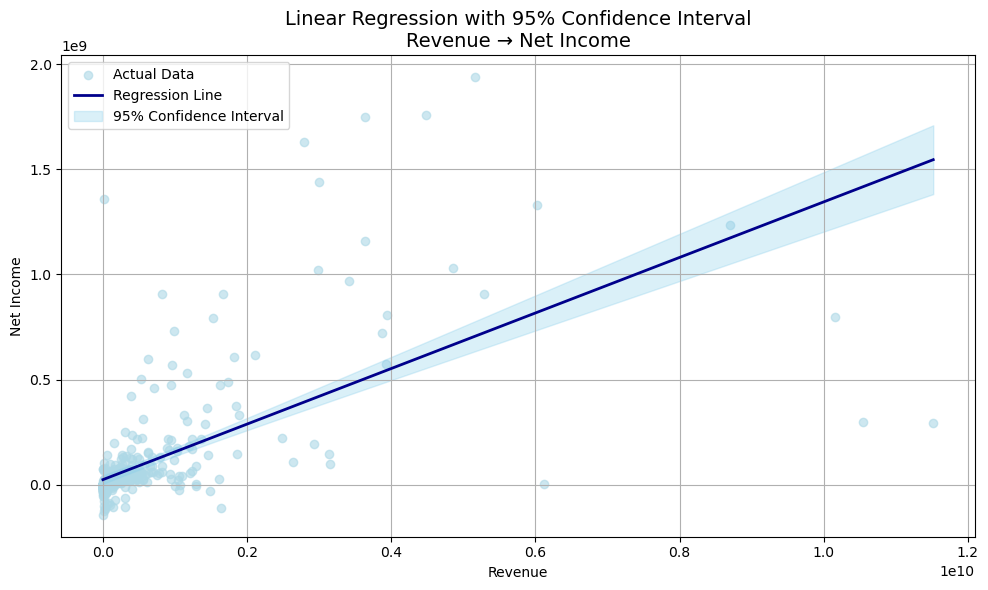

In [87]:
# Data preparation with 1% outlier trimming
df_lr = edf.dropna(subset=['Revenue', 'Net Income'])
lower_rev, upper_rev = df_lr['Revenue'].quantile([0.01, 0.99])
lower_ni, upper_ni = df_lr['Net Income'].quantile([0.01, 0.99])

df_trimmed = df_lr[
    (df_lr['Revenue'].between(lower_rev, upper_rev)) &
    (df_lr['Net Income'].between(lower_ni, upper_ni))
]

# Define X and y
X = df_trimmed[['Revenue']]
y = df_trimmed['Net Income']

# Fit LinearRegression model
lin_model = LinearRegression()
lin_model.fit(X, y)
y_pred = lin_model.predict(X)

# Supplement with statsmodels for p-value and CI
X_sm = sm.add_constant(X)
ols_model = sm.OLS(y, X_sm).fit()
p_value = ols_model.pvalues['Revenue']
conf_int = ols_model.conf_int().loc['Revenue']
lower_bound, upper_bound = conf_int

# Extract metrics
intercept = lin_model.intercept_
coef = lin_model.coef_[0]
r2_sklearn = r2_score(y, y_pred)
r_squared = ols_model.rsquared
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

markdown_output = f"""
### Hypothesis Test 5b: Revenue → Net Income (Linear Regression, 1% Outlier Removal)

| Metric                          | Value                          | Interpretation                              |
|---------------------------------|--------------------------------|----------------------------------------------|
| **Intercept (α)**               | `{intercept:.4f}`              | —                                            |
| **Coefficient (β for Revenue)** | `{coef:.4f}`                   | Positive slope implies positive effect       |
| **95% Confidence Interval (β)** | [`{lower_bound:.4f}`, `{upper_bound:.4f}`] | —                                |
| **p-value (Revenue)**           | `{p_value:.4e}` {"✅ Significant" if p_value < 0.05 else "— Not significant"} | {"Reject H₀" if p_value < 0.05 else "Fail to reject H₀"} |
| **R²**                          | `{r2_sklearn:.4f}`             | {interpret_r2(r2_sklearn)}                  |
| **Mean Squared Error (MSE)**    | `{mse:.2e}`                    | {interpret_mse(mse)}                        |
| **Root Mean Squared Error (RMSE)** | `{rmse:.2e}`               | {interpret_rmse(rmse)}                      |

**Interpretation**:
- {"There is a statistically significant positive relationship between Revenue and Net Income." if p_value < 0.05 else "There is no statistically significant linear effect of Revenue on Net Income."}
- Each unit increase in Revenue predicts an average Net Income increase of `{coef:.4f}`.
- The model explains about `{r_squared:.1%}` of the variance in Net Income.
"""

display(Markdown(markdown_output))

# Plot regression line with confidence interval
# Sort X for plotting
# Create a new DataFrame for sorting and alignment
plot_df = df_trimmed[['Revenue', 'Net Income']].copy()
plot_df['y_pred'] = y_pred
plot_df = plot_df.sort_values(by='Revenue')

X_sorted = plot_df['Revenue'].values
y_sorted = plot_df['Net Income'].values
y_pred_sorted = plot_df['y_pred'].values

# Compute confidence interval
n = len(X_sorted)
t_value = stats.t.ppf(0.975, df=n - 2)
mean_x = np.mean(X_sorted)
s_err = np.sqrt(np.sum((y_sorted - y_pred_sorted)**2) / (n - 2))
conf = t_value * s_err * np.sqrt(
    1/n + (X_sorted - mean_x)**2 / np.sum((X_sorted - mean_x)**2)
)

lower = y_pred_sorted - conf
upper = y_pred_sorted + conf

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_sorted, y_sorted, color='lightblue', alpha=0.6, label='Actual Data')
plt.plot(X_sorted, y_pred_sorted, color='darkblue', linewidth=2, label='Regression Line')
plt.fill_between(X_sorted, lower, upper, color='skyblue', alpha=0.3, label='95% Confidence Interval')

plt.title('Linear Regression with 95% Confidence Interval\nRevenue → Net Income', fontsize=14)
plt.xlabel('Revenue')
plt.ylabel('Net Income')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()